In [4]:
import json, yaml
import os
import h5py as h5
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import gridspec
import matplotlib.ticker as mtick
import torch.nn as nn
import sys
import joblib

In [5]:
import torch
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print("Device: ",device)

Device:  cuda


## Dataset1 photon and pion

In [ ]:
import pandas as pd
import numpy as np
import h5py
import glob
import pickle

""" Based on high-stats data of https://opendata.cern.ch/record/15012# 
    steps:
        - load csv
        - check for nans
        - save incident energies and showers to an array
        - create m hdf5 files, each with N events (size of actual GAN training sets)
        - have the samples shuffled before saving

"""
folder = '../calochallenge/data/photon_highstat/'

# number of events in the training dataset of ATLAS
# even though we have more events in the high-stats dataset, we only use this reduced amount
num_events = {256: 10000, 512: 10000, 1024: 10000, 2048: 10000, 4096: 10000, 8192: 10000,
              16384: 10000, 32768: 10000, 65536: 10000, 131072: 10000, 262144: 10000, 
              524288: 5000, 1048576: 3000, 2097152: 2000, 4194304: 1000}

# number of output files generated with event numbers as specified above.
# despite of what is written above, we are interested in having more data for evaluating the generative models.
num_datasets = 3

energies = [None for _ in range(num_datasets)]
showers = [None for _ in range(num_datasets)]

for i, n in enumerate(range(8,23)):
    energy = float(2**n)
    file_name = folder+'pid22_E'+str(2**n)+'_eta_20_25_voxalisation.csv'
    loaded_array = pd.read_csv(file_name, header=None).to_numpy()
    if np.isnan(loaded_array[:num_events[energy]]).any():
        raise ValueError("Dataset contains NaNs!")
    assert num_datasets*num_events[energy] <= len(loaded_array), "Not enough events in source file for E = {} MeV!".format(energy)
    for dataset_nr in range(num_datasets):
        if i == 0:
            energies[dataset_nr] = energy*np.ones(num_events[energy])
            showers[dataset_nr] = loaded_array[num_events[energy]*(dataset_nr):num_events[energy]*(dataset_nr+1)]
        else:
            energies[dataset_nr] = np.append(energies[dataset_nr], energy*np.ones(num_events[energy]))
            showers[dataset_nr] = np.append(showers[dataset_nr], loaded_array[num_events[energy]*(dataset_nr):num_events[energy]*(dataset_nr+1)], axis=0)
    print("Done with energy {}.".format(energy))

for i in range(num_datasets):
    dataset_file = h5py.File(folder+'dataset_1_photons_{}.hdf5'.format(int(i+1)), 'w')

    shuffled_idx = np.arange(len(energies[0]))
    np.random.shuffle(shuffled_idx)

    dataset_file.create_dataset('incident_energies', 
                                data=energies[i].clip(min=0.).reshape(len(energies[i]), -1)[shuffled_idx], 
                                compression='gzip')
    dataset_file.create_dataset('showers', 
                                data=showers[i].clip(min=0.).reshape(len(showers[i]), -1)[shuffled_idx], 
                                compression='gzip')
    print("Done with writing file {}".format(i+1))
    dataset_file.close()

In [ ]:
""" Based on high-stats data of https://opendata.cern.ch/record/15012# 
    steps:
        - load csv
        - check for nans
        - save incident energies and showers to an array
        - create m hdf5 files, each with N events (size of actual GAN training sets)
        - have the samples shuffled before saving

"""
folder = '../calochallenge/data/pion_samples/'

# number of events in the training dataset of ATLAS
# even though we have more events in the high-stats dataset, we only use this reduced amount

# NOT USED FOR NOW AS PIONS ARE NOT YET HIGH_STAT
num_events = {256: 10000, 512: 10000, 1024: 10000, 2048: 10000, 4096: 10000, 8192: 10000,
              16384: 10000, 32768: 10000, 65536: 10000, 131072: 10000, 262144: 10000, 
              524288: 5000, 1048576: 3000, 2097152: 2000, 4194304: 1000}

# USED NOW, LOW STAT DATA:
num_events = {256: 10000, 512: 10000, 1024: 10000, 2048: 10000, 4096: 10000, 8192: 10000,
              16384: 10000, 32768: 10000, 65536: 10000, 131072: 10000, 262144: 10000, 
              524288: 5000, 1048576: 3000, 2097152: 2000, 4194304: 230}


# number of output files generated with event numbers as specified above.
# despite of what is written above, we are interested in having more data for evaluating the generative models.
num_datasets = 1

energies = [None for _ in range(num_datasets)]
showers = [None for _ in range(num_datasets)]

for i, n in enumerate(range(8,23)):
    energy = float(2**n)
    file_name = folder+'pid211_E'+str(2**n)+'_eta_20_25_voxalisation.csv'
    loaded_array = pd.read_csv(file_name, header=None).to_numpy()
    if np.isnan(loaded_array[:num_events[energy]]).any():
        raise ValueError("Dataset contains NaNs!")
    assert num_datasets*num_events[energy] <= len(loaded_array), "Not enough events in source file for E = {} MeV!".format(energy)
    for dataset_nr in range(num_datasets):
        if i == 0:
            energies[dataset_nr] = energy*np.ones(num_events[energy])
            showers[dataset_nr] = loaded_array[num_events[energy]*(dataset_nr):num_events[energy]*(dataset_nr+1)]
        else:
            energies[dataset_nr] = np.append(energies[dataset_nr], energy*np.ones(num_events[energy]))
            showers[dataset_nr] = np.append(showers[dataset_nr], loaded_array[num_events[energy]*(dataset_nr):num_events[energy]*(dataset_nr+1)], axis=0)
    print("Done with energy {}.".format(energy))

for i in range(num_datasets):
    dataset_file = h5py.File(folder+'dataset_1_pions_{}.hdf5'.format(int(i+1)), 'w')

    shuffled_idx = np.arange(len(energies[0]))
    np.random.shuffle(shuffled_idx)

    dataset_file.create_dataset('incident_energies', 
                                data=energies[i].clip(min=0.).reshape(len(energies[i]), -1)[shuffled_idx], 
                                compression='gzip')
    dataset_file.create_dataset('showers', 
                                data=showers[i].clip(min=0.).reshape(len(showers[i]), -1)[shuffled_idx], 
                                compression='gzip')
    print("Done with writing file {}".format(i+1))
    dataset_file.close()

## Dataset 2/3

In [ ]:

folder = '../calochallenge/data/test/'
sampling_fraction = 1./0.033

energy = []
shower = []

output_nr = 1

for idx, source_file in enumerate(glob.glob(folder+'*')):
    data_source = h5py.File(source_file, 'r')

    for key in data_source["Angle_90"].keys():
        energy.append(float(key))
        shower.append(data_source["Angle_90"][key][:])
    data_source.close()
    print("Done with reading file {}/{}".format(idx+1, len(glob.glob(folder+'*'))-output_nr+1))
    if idx % 1 == 0:
        energy = np.array(energy)
        print(len(energy))
        shower = np.array(shower)
        print(shower.shape)
        shower = np.moveaxis(shower, 3, 1)
        print(shower.shape)
        shower = np.moveaxis(shower, 3, 2)
        print(shower.shape)
        
        shuffled_idx = np.arange(len(energy))
        np.random.shuffle(shuffled_idx)


        dataset_file = h5py.File(folder + 'dataset_2_{}.hdf5'.format(output_nr), 'w')
        dataset_file.create_dataset('incident_energies', data=energy.clip(min=0.).reshape(len(energy), -1)[shuffled_idx], compression='gzip')
        dataset_file.create_dataset('showers', data=sampling_fraction*shower.clip(min=0.).reshape(len(shower), -1)[shuffled_idx], compression='gzip')
        print("Done with writing file {}".format(output_nr))
        dataset_file.close()
        output_nr += 1
        energy = []
        shower = []

## Binning for shower and layer

This part gives the form of data we want to train or pre-processed, 1d or 3d, per layer or per shower, cylindrical or cartesian, the binning can be found in `/binning` directory, where the r_edges * n_bin_alpha corresponds to number of index should be in each layer.

Take dataset 1 as an example

In [2]:

#Dataset1 photon
def DataLoader(file_name,shape,
               nevts,emax,emin,
               max_deposit=2,
               logE=True,
               use_1D=False,
               rank=0,size=1):
    

    with h5.File(file_name,"r") as h5f:
        e = h5f['incident_energies'][rank:int(nevts):size].astype(np.float32)/1000.0 #in GeV
        shower = h5f['showers'][rank:int(nevts):size].astype(np.float32)/1000.0 # in GeV
           
    if use_1D:
        #Different number of dimensions per layer
        layer1 = np.sum(shower[:,:8],-1,keepdims=True)
        shower[:,:8]=np.ma.divide(shower[:,:8],layer1).filled(0)
        layer2 = np.sum(shower[:,8:168],-1,keepdims=True)
        shower[:,8:168]=np.ma.divide(shower[:,8:168],layer2).filled(0)
        layer3 = np.sum(shower[:,168:358],-1,keepdims=True)
        shower[:,168:358]=np.ma.divide(shower[:,168:358],layer3).filled(0)
        layer4 = np.sum(shower[:,358:363],-1,keepdims=True)
        shower[:,358:363]=np.ma.divide(shower[:,358:363],layer4).filled(0)
        layer5 = np.sum(shower[:,363:],-1,keepdims=True)
        shower[:,363:]=np.ma.divide(shower[:,363:],layer5).filled(0)
        layer = np.concatenate([layer1,layer2,layer3,layer4,layer5],-1)
        shower = shower.reshape(shape)
        
    else:
        shower = shower.reshape(shape)
        layer = np.sum(shower,(2,3,4),keepdims=True)
        shower = np.ma.divide(shower,layer)

    def convert_energies(e,layer_energies):
        converted = np.zeros(layer_energies.shape,dtype=np.float32)
        converted[:,0] = np.ma.divide(np.sum(layer_energies,-1),np.squeeze(max_deposit*e)).filled(0)
        for i in range(1,layer_energies.shape[1]):
            converted[:,i] = np.ma.divide(layer_energies[:,i-1],np.sum(layer_energies[:,i-1:],-1)).filled(0)
            
        return converted

    layer = convert_energies(e,np.squeeze(layer))

    if logE:        
        return shower,layer,np.log10(e/emin)/np.log10(emax/emin)
    else:
        return shower,layer,(e-emin)/(emax-emin)

In [3]:

#Dataset1 pion
def DataLoader(file_name,shape,
               nevts,emax,emin,
               max_deposit=2,
               logE=True,
               use_1D=False,
               rank=0,size=1):
    

    with h5.File(file_name,"r") as h5f:
        e = h5f['incident_energies'][rank:int(nevts):size].astype(np.float32)/1000.0 #in GeV
        shower = h5f['showers'][rank:int(nevts):size].astype(np.float32)/1000.0 # in GeV
        
    # this is for pion binning   
    if use_1D:
        #Different number of dimensions per layer
        layer1 = np.sum(shower[:,:8],-1,keepdims=True)
        shower[:,:8]=np.ma.divide(shower[:,:8],layer1).filled(0)
        layer2 = np.sum(shower[:,8:108],-1,keepdims=True)
        shower[:,8:108]=np.ma.divide(shower[:,8:108],layer2).filled(0)
        layer3 = np.sum(shower[:,108:208],-1,keepdims=True)
        shower[:,108:208]=np.ma.divide(shower[:,108:208],layer3).filled(0)
        layer4 = np.sum(shower[:,208:213],-1,keepdims=True)
        shower[:,208:213]=np.ma.divide(shower[:,208:213],layer4).filled(0)
        layer5 = np.sum(shower[:,213:363],-1,keepdims=True)
        shower[:,213:363]=np.ma.divide(shower[:,213:363],layer5).filled(0)
        layer6 = np.sum(shower[:,363:523],-1,keepdims=True)
        shower[:,363:523]=np.ma.divide(shower[:,363:523],layer6).filled(0)
        layer7 = np.sum(shower[:,523:],-1,keepdims=True)
        shower[:,523:]=np.ma.divide(shower[:,523:],layer7).filled(0)
        layer = np.concatenate([layer1,layer2,layer3,layer4,layer5,layer6,layer7],-1)
        shower = shower.reshape(shape)
        
    else:
        shower = shower.reshape(shape)
        layer = np.sum(shower,(2,3,4),keepdims=True)
        shower = np.ma.divide(shower,layer)

    def convert_energies(e,layer_energies):
        converted = np.zeros(layer_energies.shape,dtype=np.float32)
        converted[:,0] = np.ma.divide(np.sum(layer_energies,-1),np.squeeze(max_deposit*e)).filled(0)
        for i in range(1,layer_energies.shape[1]):
            converted[:,i] = np.ma.divide(layer_energies[:,i-1],np.sum(layer_energies[:,i-1:],-1)).filled(0)
            
        return converted

    layer = convert_energies(e,np.squeeze(layer))

    if logE:        
        return shower,layer,np.log10(e/emin)/np.log10(emax/emin)
    else:
        return shower,layer,(e-emin)/(emax-emin)

The correct config parameters (E_max/min, sample_size, max_deposit) are copied from the Calodiffusion repo, which can be found in `/binning` directory

* For quick test, can use 1D with some simple net and get some intuitive results
* Usually recommand 3D array (either cylindrical or cart) with some conditional Unet to perform great results

In [31]:
shower, layer_photon, loge = DataLoader('../../calochallenge/data/dataset_1_photons_1.hdf5',[-1,368,1],
               120230,4194.304,0.256,
               max_deposit=3.1,
               logE=True,
               use_1D=True,
               rank=0,size=1)

## High Level Feature Visualization


In [7]:
from HighLevelFeatures import HighLevelFeatures as HLF
import numpy as np
import h5py
import matplotlib.pyplot as plt

In [8]:
# creating instance of HighLevelFeatures class to handle geometry based on binning file
HLF_1_pions = HLF('pion', filename='binning/binning_dataset_1_pions.xml')

In [11]:
pion_file = h5py.File('../../calochallenge/data/dataset_1_pions_1.hdf5', 'r')

In [12]:
for dataset in pion_file:
    # name of the datasets:
    print("dataset name: ", dataset)
    print("dataset shape:", pion_file[dataset][:].shape)

dataset name:  incident_energies
dataset shape: (120230, 1)
dataset name:  showers
dataset shape: (120230, 533)


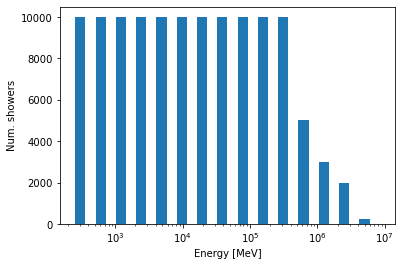

In [13]:


# incident energies are discrete, starting at 256 MeV and increasing in powers of 2. At high energies,
# there are fewer than 10k events per energy 
energies = pion_file['incident_energies'][:]

bins = np.logspace(8,23,31, base=2)
plt.hist(energies, bins=bins)
plt.xscale('log')
plt.xlabel('Energy [MeV]')
plt.ylabel('Num. showers')
plt.show()

In [14]:


# save total number of events in dataset_1_photons_1.hdf5
n_events = pion_file["incident_energies"].shape[0]
print('Total number of events: ',n_events)

# save number of alpha bins in each layer
num_alpha = HLF_1_pions.num_alpha
print('Number of alpha bins per layer: ', num_alpha)

#save the r edges in each layer
r_edges = HLF_1_pions.r_edges
print('r_edges: ', r_edges)

#save total number of calorimeter layers
n_layers = len(num_alpha)
print('Number of calorimeter layers: ',n_layers)



Total number of events:  120230
Number of alpha bins per layer:  [1, 10, 10, 1, 10, 10, 1]
r_edges:  [[0.0, 5.0, 10.0, 30.0, 50.0, 100.0, 200.0, 400.0, 600.0], [0.0, 1.0, 4.0, 7.0, 10.0, 15.0, 30.0, 50.0, 90.0, 150.0, 200.0], [0.0, 5.0, 10.0, 20.0, 30.0, 50.0, 80.0, 130.0, 200.0, 300.0, 400.0], [0.0, 50.0, 100.0, 200.0, 400.0, 600.0], [0.0, 10.0, 20.0, 30.0, 50.0, 80.0, 100.0, 130.0, 160.0, 200.0, 250.0, 300.0, 350.0, 400.0, 1000.0, 2000.0], [0.0, 10.0, 20.0, 30.0, 50.0, 80.0, 100.0, 130.0, 160.0, 200.0, 250.0, 300.0, 350.0, 400.0, 600.0, 1000.0, 2000.0], [0.0, 50.0, 100.0, 150.0, 200.0, 250.0, 300.0, 400.0, 600.0, 1000.0, 2000.0]]
Number of calorimeter layers:  7


In [15]:
# save number of r bins per layer
r_bins = []
for layer in range(n_layers):
    r_bins.append(len(r_edges[layer])-1)
print('Number of radius bins per layer: ', r_bins)

# save layer edges
layer_edges = []
for layer in range(n_layers):
    layer_edges.append(num_alpha[layer]*r_bins[layer])
print('Layer edges: ',layer_edges)

Number of radius bins per layer:  [8, 10, 10, 5, 15, 16, 10]
Layer edges:  [8, 100, 100, 5, 150, 160, 10]


In [16]:
# format 'energies' and store incident energies
energies = pion_file["incident_energies"]
print('energies shape: ',energies.shape)
print(energies)
#format 'layer_0' and store energies
layer_0 = pion_file["showers"][:,:layer_edges[0]]
print('layer_0 shape: ',layer_0.shape)

#format 'layer_1' and store energies
layer_1 = pion_file["showers"][:,(layer_edges[0]):(layer_edges[0]+layer_edges[1])]
print('layer_1 shape: ',layer_1.shape)

#format 'layer_2' and store energies
layer_2 = pion_file["showers"][:,(layer_edges[0]+layer_edges[1]):(layer_edges[0]+layer_edges[1]+layer_edges[2])]
print('layer_2 shape: ',layer_2.shape)

#format 'layer_3' and store energies
layer_3 = pion_file["showers"][:,(layer_edges[0]+layer_edges[1]+layer_edges[2]):(layer_edges[0]+layer_edges[1]+layer_edges[2]+layer_edges[3])]
print('layer_3 shape: ',layer_3.shape)

#format 'layer_4' and store energies
layer_4 = pion_file["showers"][:,(layer_edges[0]+layer_edges[1]+layer_edges[2]+layer_edges[3]):(layer_edges[0]+layer_edges[1]+layer_edges[2]+layer_edges[3]+layer_edges[4])]
print('layer_4 shape: ',layer_4.shape)

#format 'layer_5' and store energies
layer_5 = pion_file["showers"][:,(layer_edges[0]+layer_edges[1]+layer_edges[2]+layer_edges[3]+layer_edges[4]):(layer_edges[0]+layer_edges[1]+layer_edges[2]+layer_edges[3]+layer_edges[4]+layer_edges[5])]
print('layer_5 shape: ',layer_5.shape)

#format 'layer_6' and store energies
layer_6 = pion_file["showers"][:,(layer_edges[0]+layer_edges[1]+layer_edges[2]+layer_edges[3]+layer_edges[4]+layer_edges[5]):(layer_edges[0]+layer_edges[1]+layer_edges[2]+layer_edges[3]+layer_edges[4]+layer_edges[5]+layer_edges[6])]
print('layer_6 shape: ',layer_6.shape)

energies shape:  (120230, 1)
<HDF5 dataset "incident_energies": shape (120230, 1), type "<f8">
layer_0 shape:  (120230, 8)
layer_1 shape:  (120230, 100)
layer_2 shape:  (120230, 100)
layer_3 shape:  (120230, 5)
layer_4 shape:  (120230, 150)
layer_5 shape:  (120230, 160)
layer_6 shape:  (120230, 10)


In [17]:
# Create reformatted datafile
filename = './piplus_teacher.hdf5' #rename accordingly
save_file = h5py.File(filename, 'w')

save_file.create_dataset('layer_0', data=layer_0)
save_file.create_dataset('layer_1', data=layer_1)
save_file.create_dataset('layer_2', data=layer_2)
save_file.create_dataset('layer_3', data=layer_3)
save_file.create_dataset('layer_4', data=layer_4)
save_file.create_dataset('layer_5', data=layer_5)
save_file.create_dataset('layer_6', data=layer_6)
save_file.create_dataset('energy', data=energies)
    
save_file.close()

In [23]:
HLF_1_pions.CalculateFeatures(pion_file["showers"][:])

In [24]:
#example plot for 2 layer braw pion energy
raw_layerE = [[]]*4

num_evt = 5000
for i in range(4):
    raw_layerE[i] = np.append(raw_layerE[i],HLF_1_pions.GetElayers()[i][0:num_evt])
raw_layerE = np.vstack((raw_layerE[0],raw_layerE[1],raw_layerE[2],raw_layerE[3]))


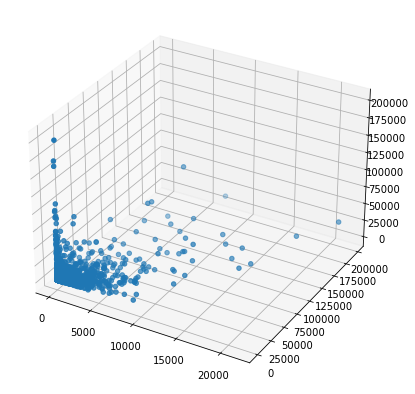

In [27]:
fig = plt.figure(figsize=(12,7))
ax = fig.add_subplot(projection='3d')
ax.scatter(raw_layerE[0],raw_layerE[1],raw_layerE[3])

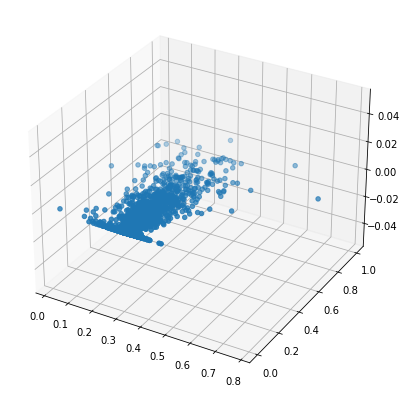

In [32]:
#example plot for 2 layer binned photon energy
fig = plt.figure(figsize=(12,7))
ax = fig.add_subplot(projection='3d')
ax.scatter(layer_photon[0:5000,0],layer_photon[0:5000,1])

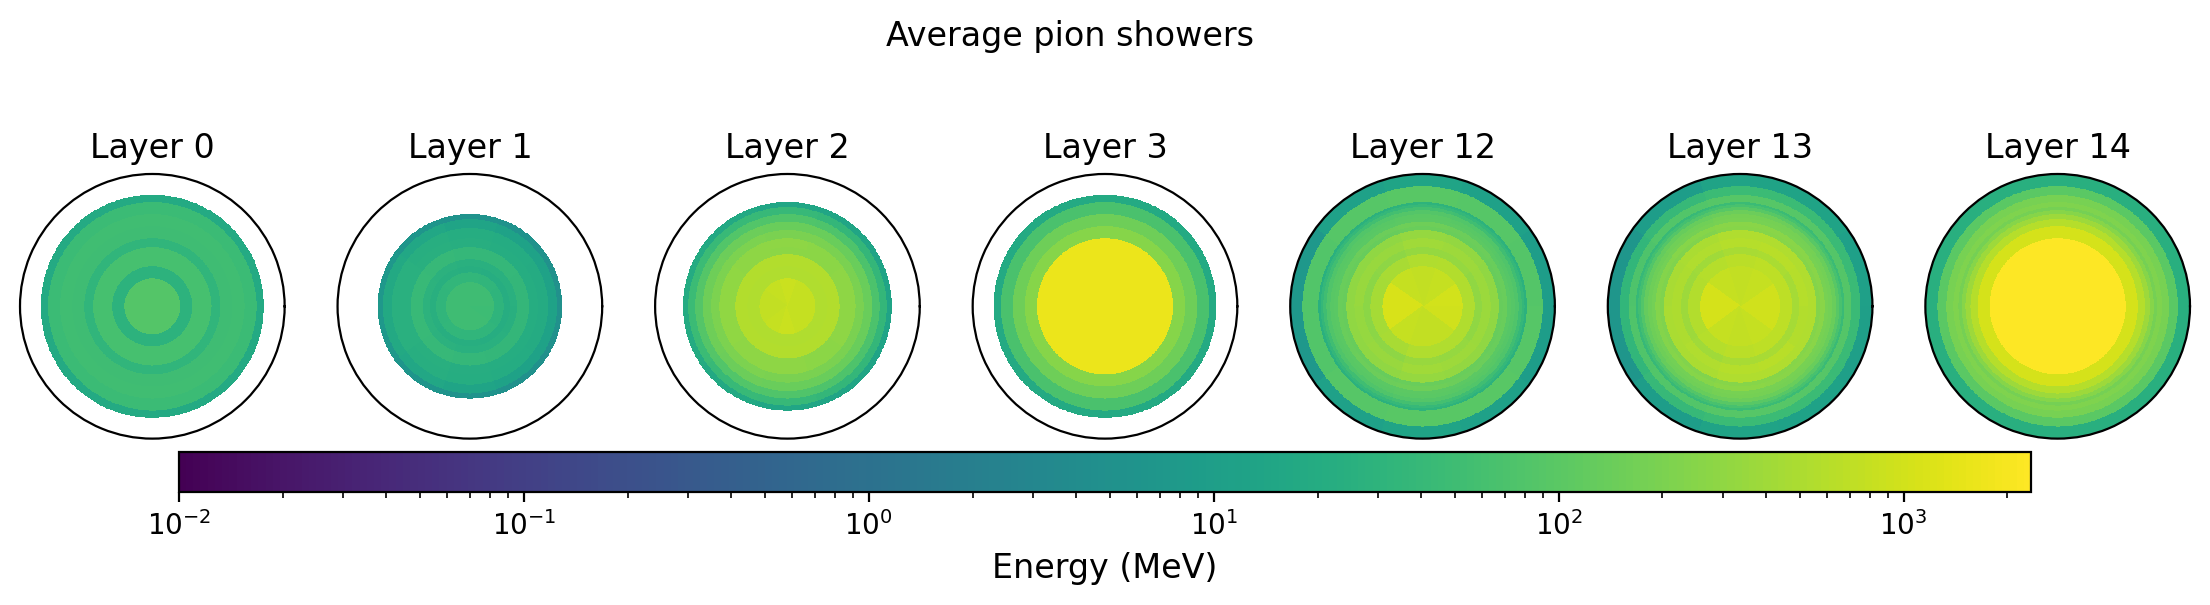

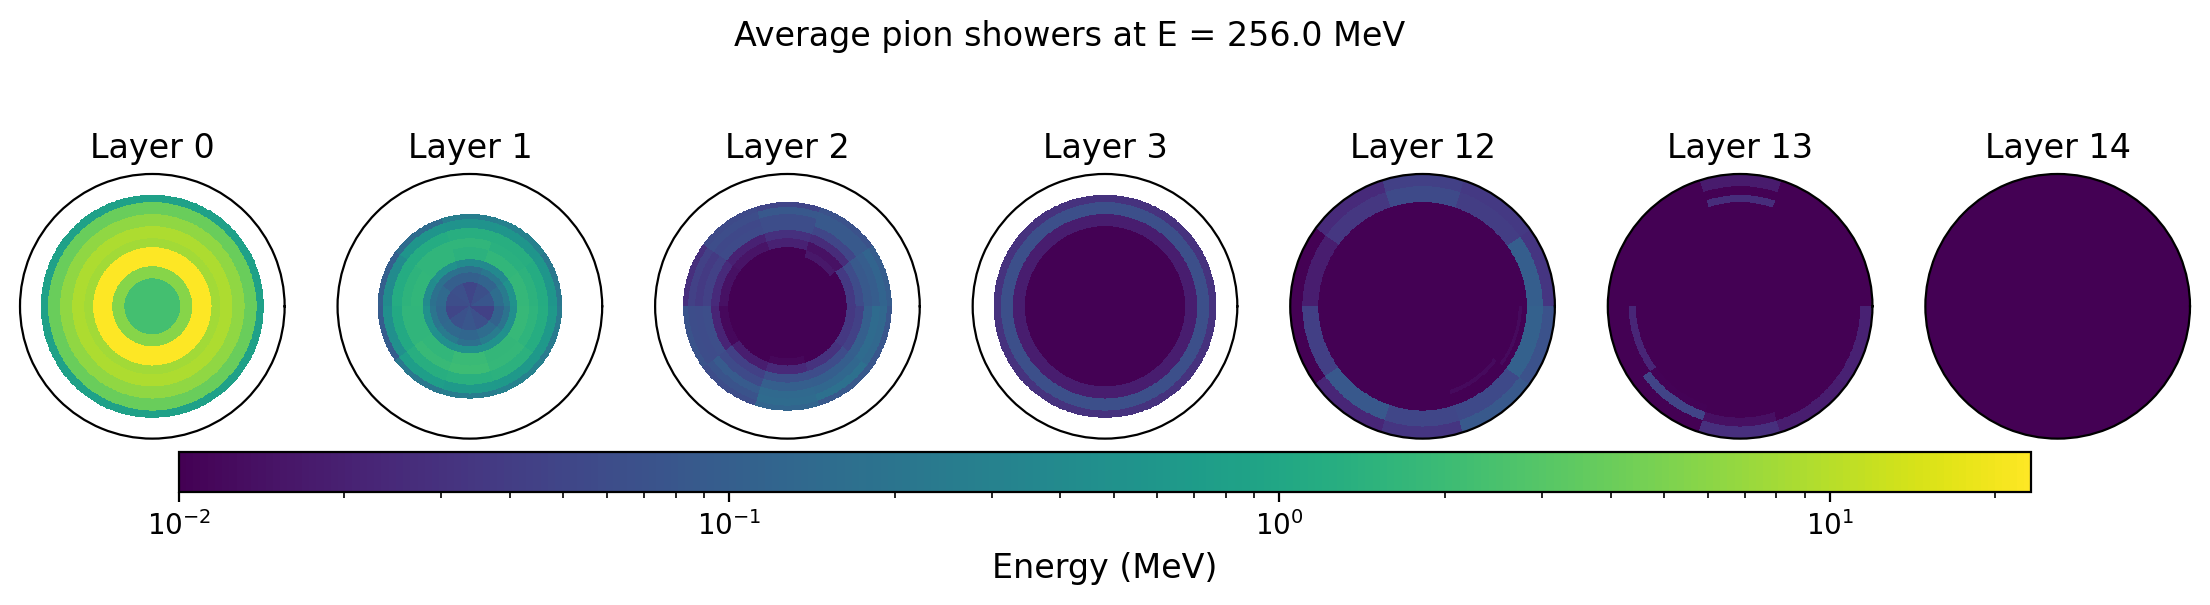

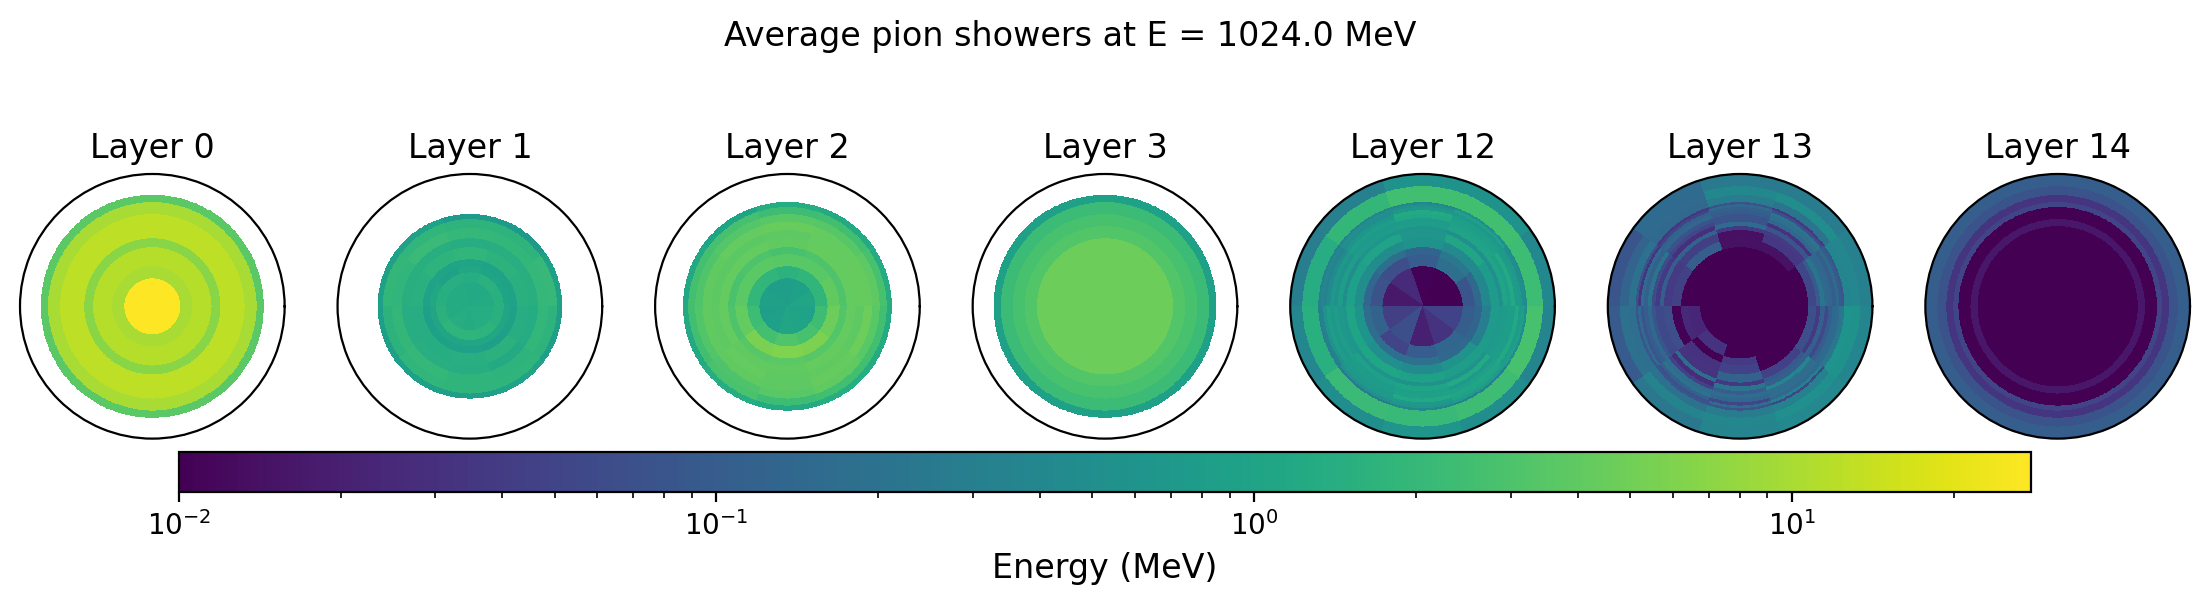

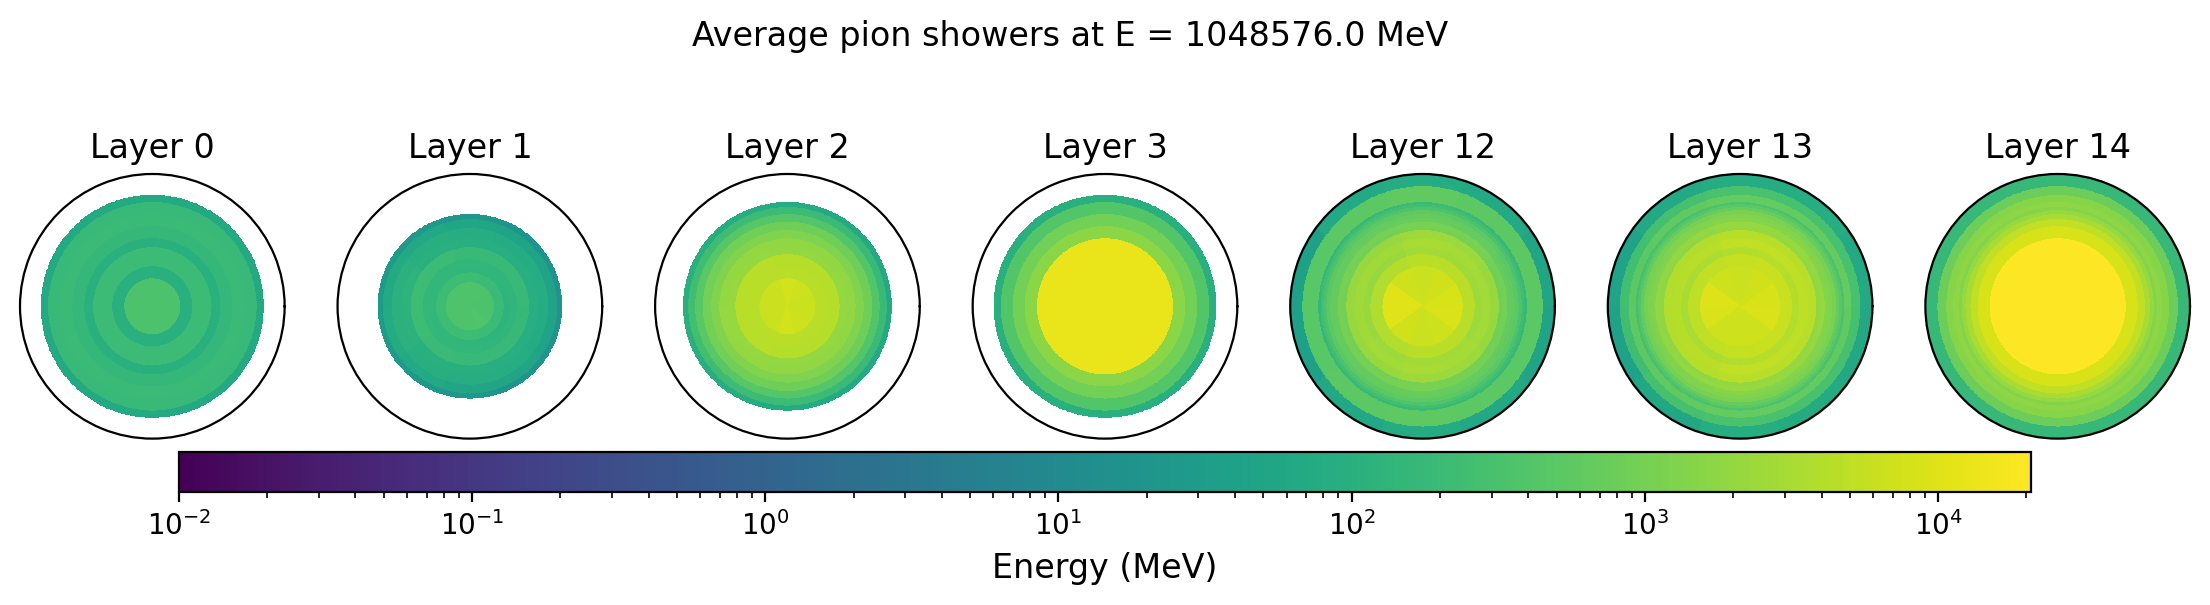

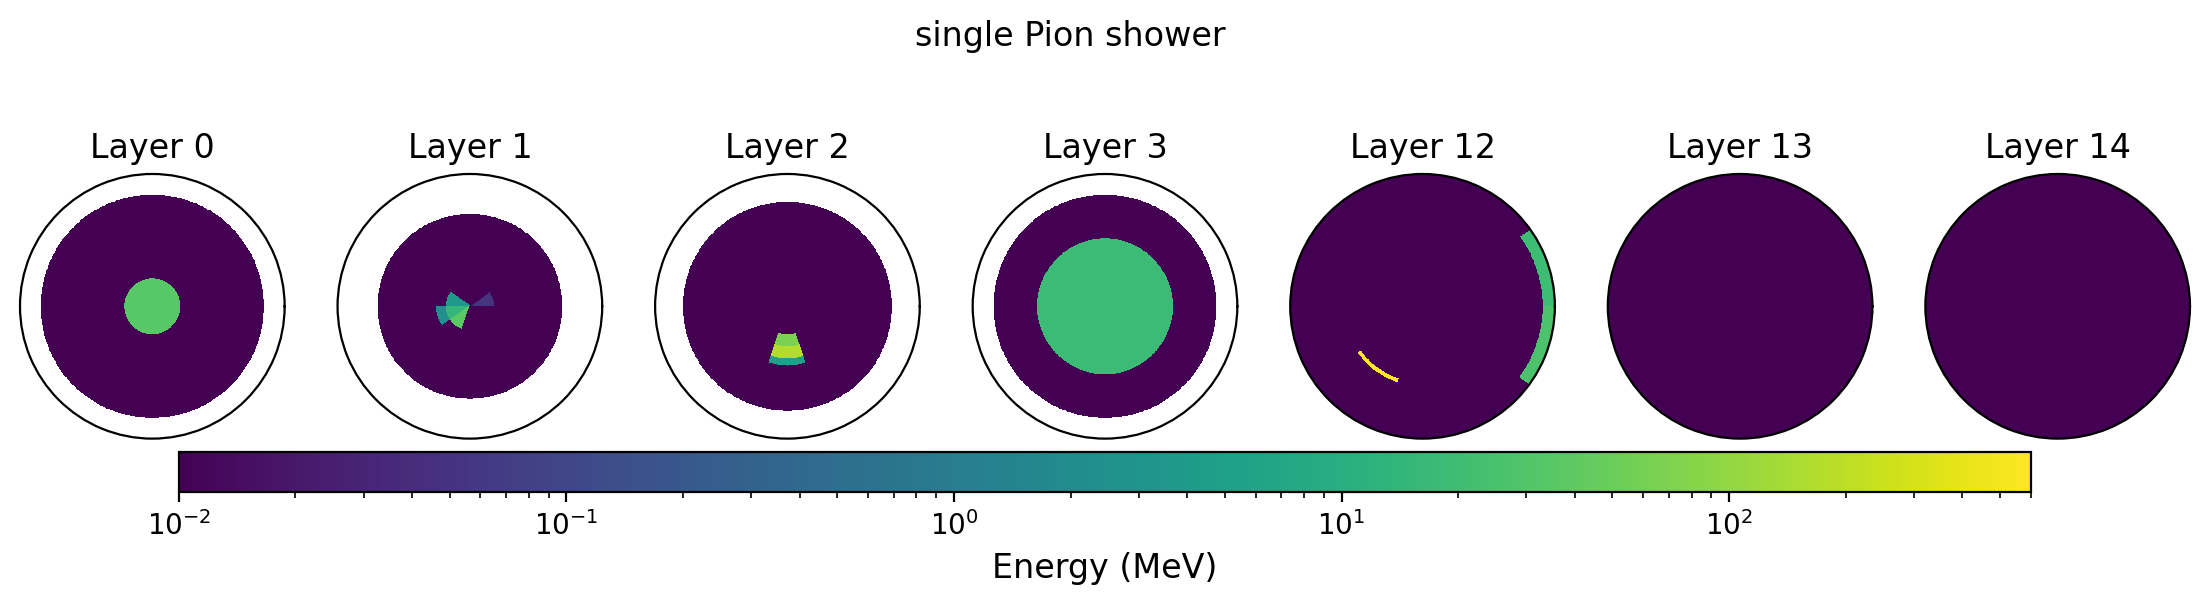

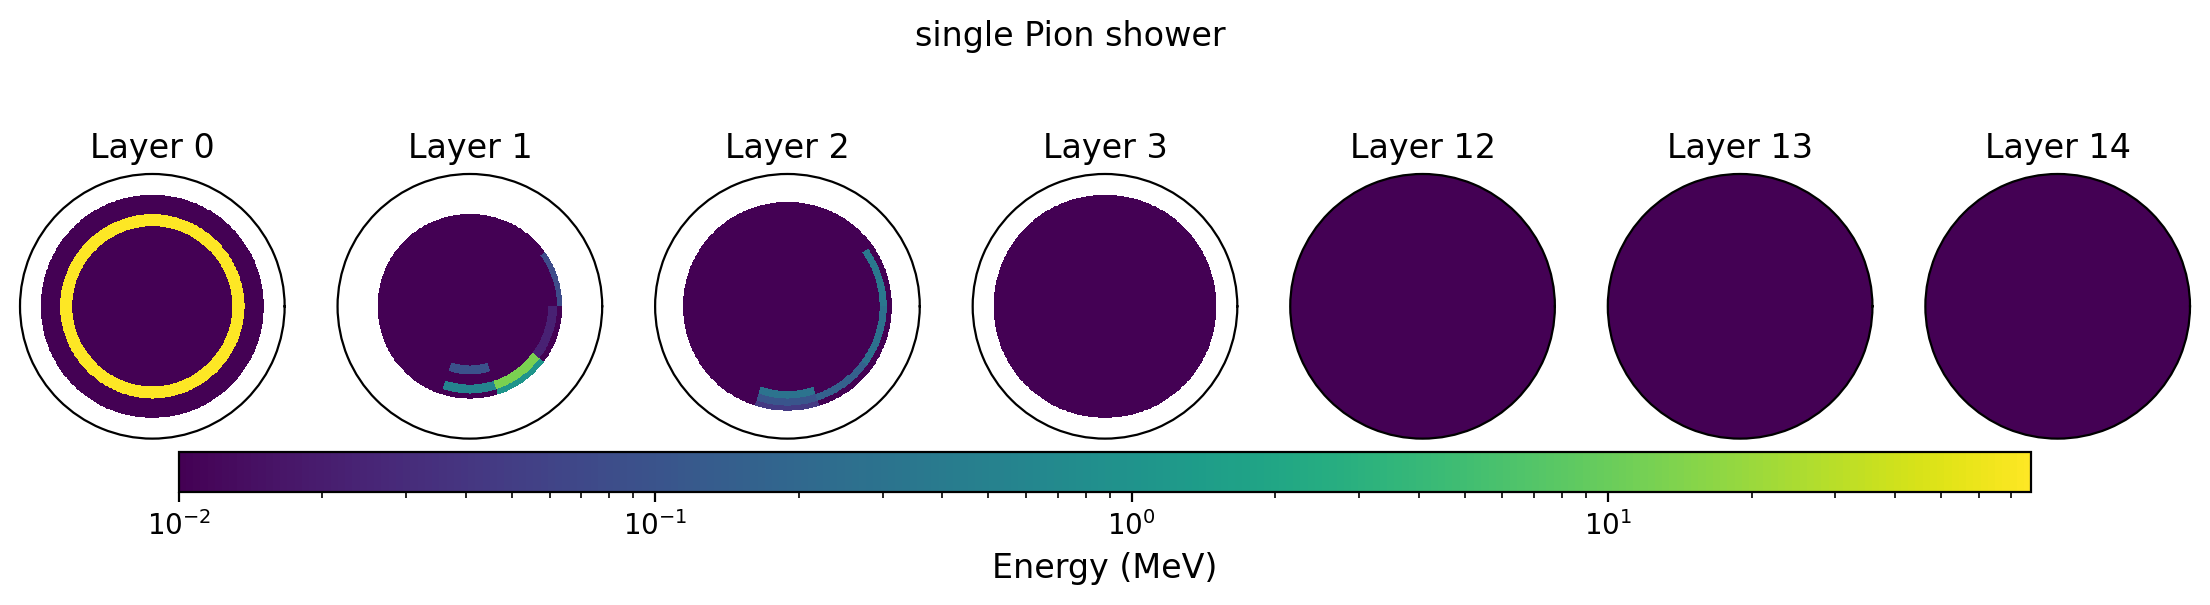

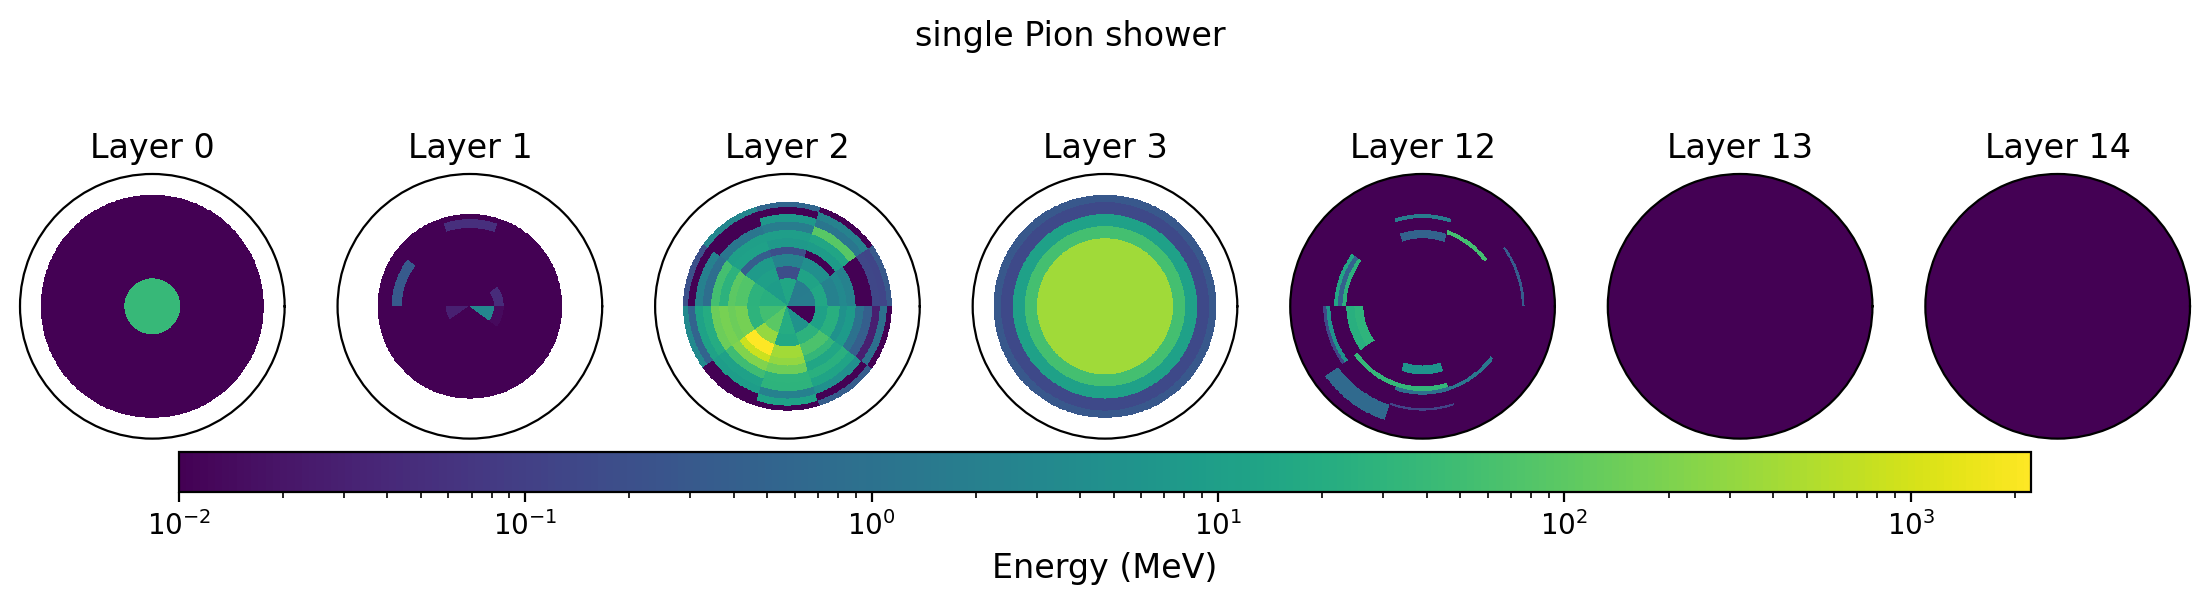

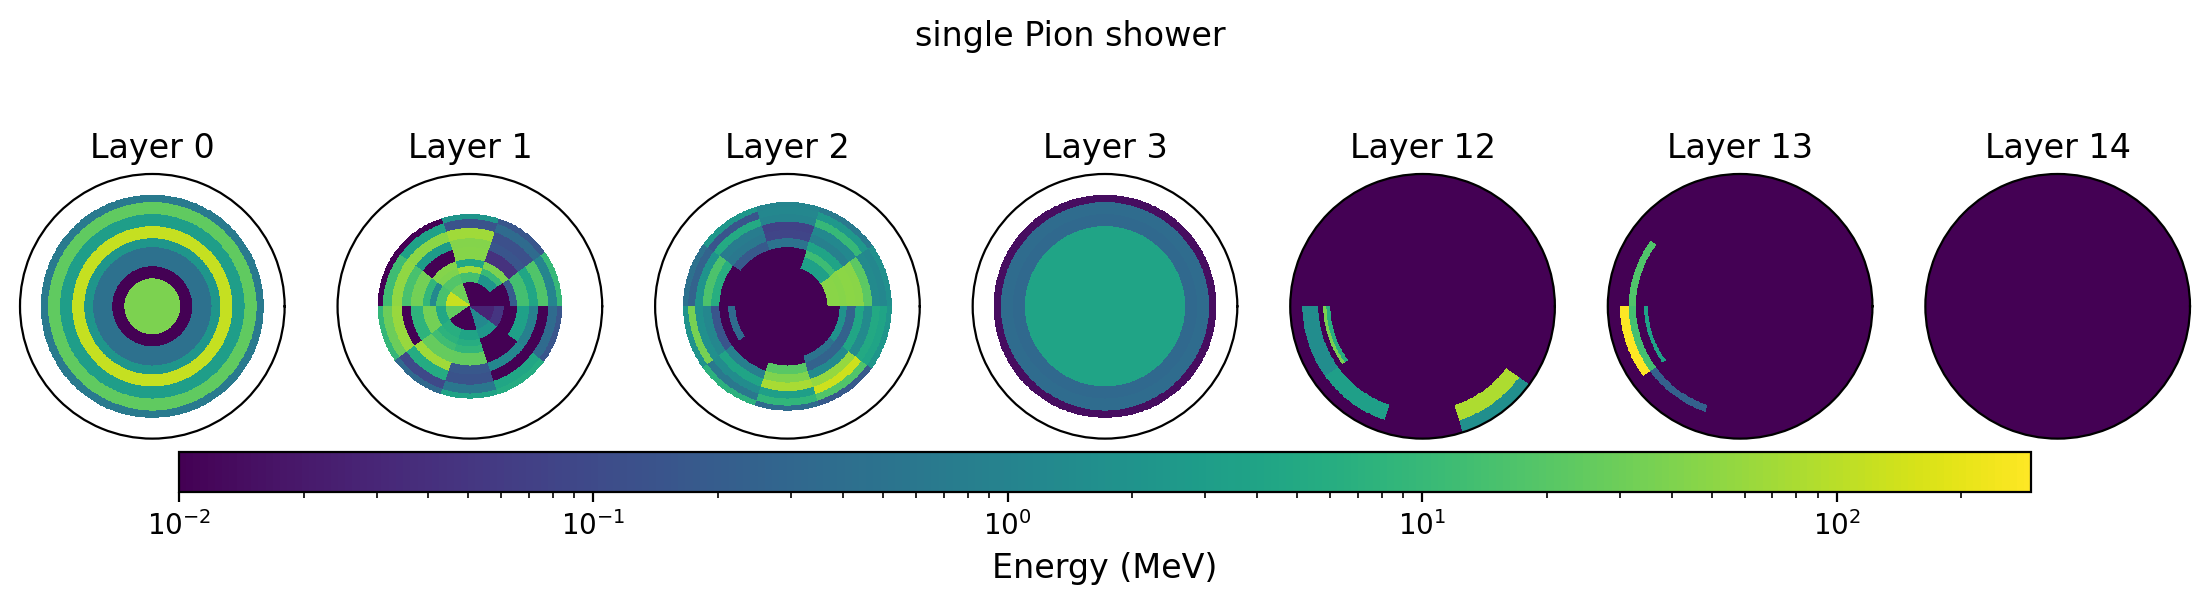

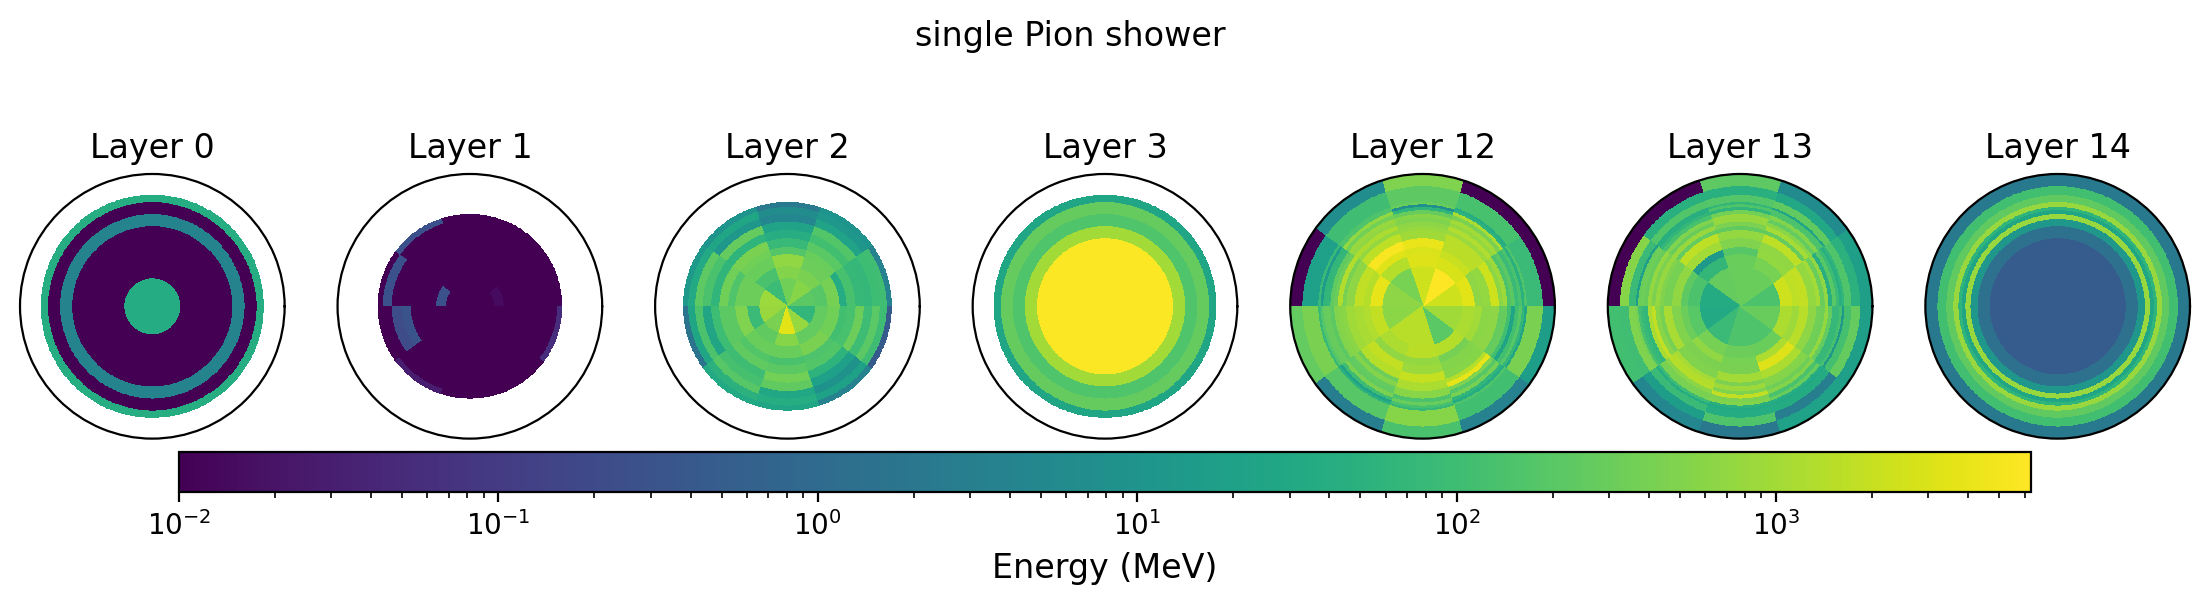

In [33]:
_ = HLF_1_pions.DrawAverageShower(pion_file['showers'][:], title="Average pion showers")
# averages at fixed energies:

for energy in [256., 1024., 1048576.]:
    voxel_dim = pion_file['showers'].shape[1]
    # hdf5 indexing must match the shape of the dataset:
    energy_idx = np.tile(pion_file['incident_energies'][:]==energy, voxel_dim)
    # and then be reshaped:
    _ = HLF_1_pions.DrawAverageShower(pion_file['showers'][energy_idx].reshape(-1, voxel_dim), 
                                        filename=None, title="Average pion showers at E = {} MeV".format(energy))
    
_ = HLF_1_pions.DrawSingleShower(pion_file['showers'][:5],
                                title="single Pion shower")

In [2]:
HLF_2 = HLF('electron', filename='binning/binning_dataset_2.xml')

In [3]:
some_file = h5py.File('../../calochallenge/data/test/dataset_2_1.hdf5', 'r') # or dataset_2_2.hdf5

In [4]:
for dataset in some_file:
    # name of the datasets:
    print("dataset name: ", dataset)
    print("dataset shape:", some_file[dataset].shape)

dataset name:  incident_energies
dataset shape: (2500, 1)
dataset name:  showers
dataset shape: (2500, 6480)


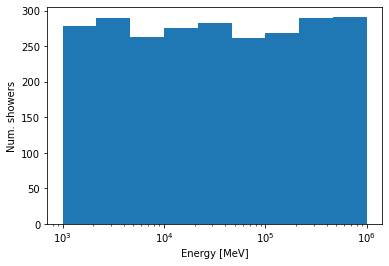

In [5]:
# incident energies are flat in logarithmic space between 1 GeV and 1 TeV:
energies = some_file['incident_energies'][:]
showers = some_file["showers"][:]

bins = np.logspace(3,6,10)
plt.hist(energies, bins=bins)
plt.xscale('log')
plt.xlabel('Energy [MeV]')
plt.ylabel('Num. showers')
plt.show()

In [6]:
# High-level features are computed once for a given dataset by calling EvaluateFeatures(data)
HLF_2.CalculateFeatures(showers)

In [7]:
# and can then be given out like this:

# total deposited energy in the shower
print("Total energy of each shower: ", HLF_2.GetEtot())
print("Average of deposited over incident energies: ", (HLF_2.GetEtot()/energies.squeeze()).mean())



# energy deposited in each layer of the geometry:
# (returns a dict with layer_number as key.
print("Energy deposited in each layer for each shower: ", HLF_2.GetElayers())
print("Average energy deposited in the first layer: ", HLF_2.GetElayers()[0].mean())
print("Average energy deposited in the last layer: ", HLF_2.GetElayers()[44].mean())


# Center of energy in eta direction:
# (only available for layer with more than one alpha bin)
print("Center of energy in eta direction for each shower: ", HLF_2.GetECEtas())
# and its width
print("Width of center of energy in eta direction for each shower: ", HLF_2.GetWidthEtas())

# Center of energy in phi direction:
# (only available for layer with more than one alpha bin)
print("Center of energy in phi direction for each shower: ", HLF_2.GetECPhis())
# and its width
print("Width of center of energy in phi direction for each shower: ", HLF_2.GetWidthEtas())

Total energy of each shower:  [ 21282.49641032   2578.45350825   4040.8339339  ... 100251.35299756
   2572.55238585 324093.93084465]
Average of deposited over incident energies:  0.7847333649196193
Energy deposited in each layer for each shower:  {0: array([386.68995558,  23.39654112,  98.31741135, ..., 336.08019264,
        13.7186701 , 693.78762056]), 1: array([ 482.89424958,   53.20634335,   93.85111882, ...,  401.19581162,
         47.01628113, 2277.04265671]), 2: array([ 664.45729073,  132.37122725,  522.46220982, ..., 1133.48763717,
        153.00705384, 2974.92702619]), 3: array([1060.25834901,  254.51919679,  190.723334  , ..., 2770.65311696,
        370.72623549, 6595.13507594]), 4: array([1786.89637436,  698.81872999,  281.17658477, ..., 3937.39480438,
        401.21420914, 9752.28551222]), 5: array([ 1653.78154892,   108.38387377,   502.96753834, ...,
        5093.70835963,   191.08946872, 13959.29632735]), 6: array([ 1962.36251226,   185.61977028,   512.56514539, ...,
     

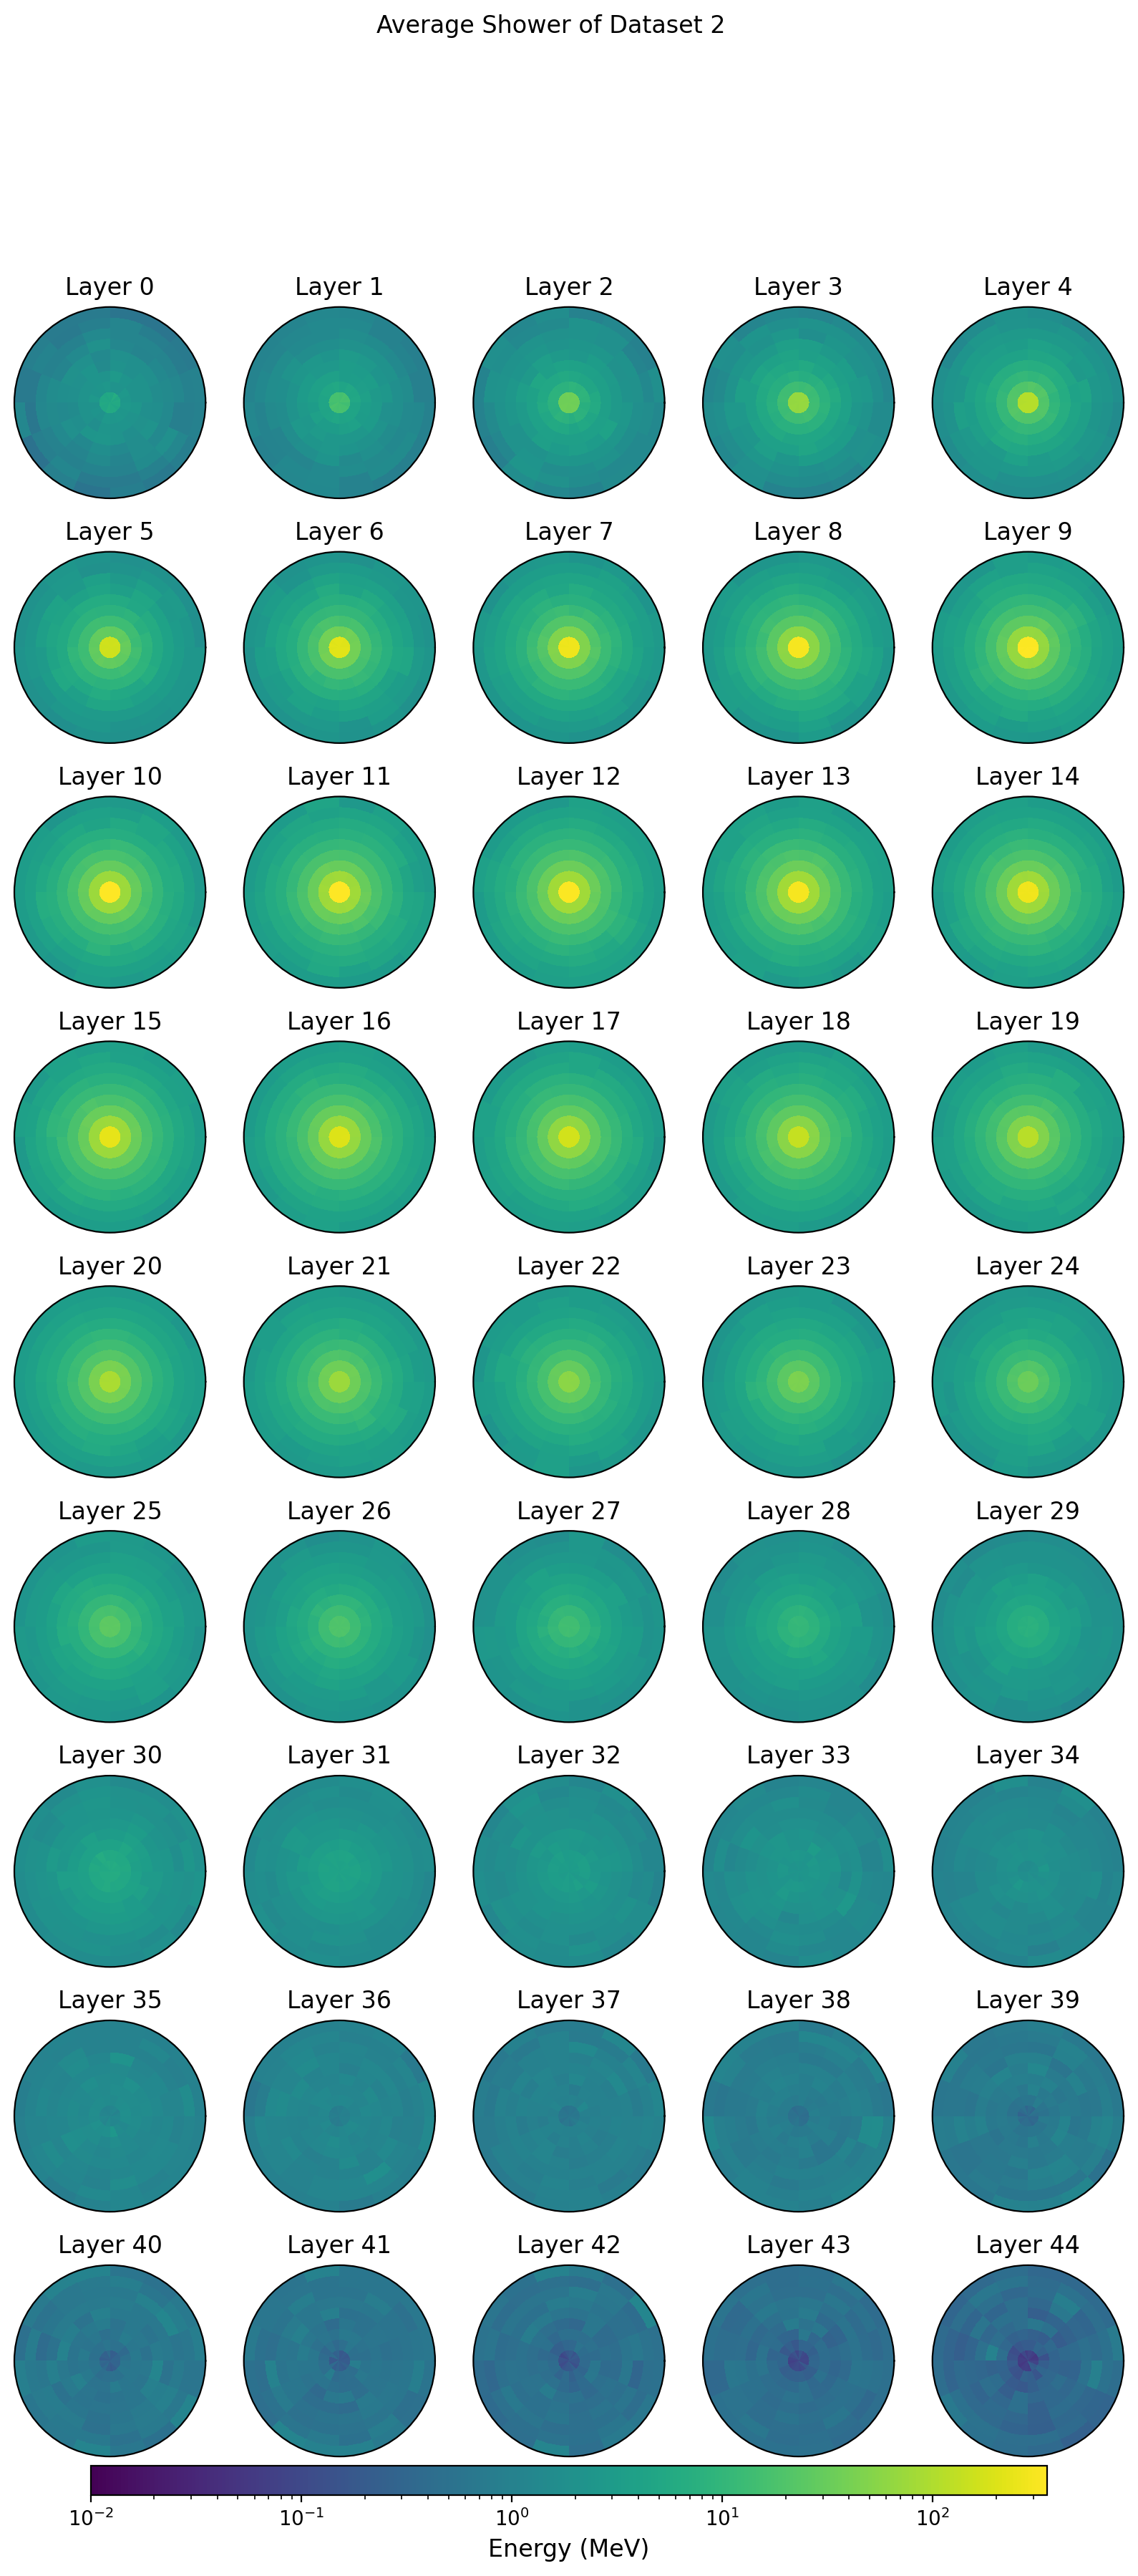

In [8]:
# looking at the average shower:
# not providing a filename or passing 'None' does not save the plot
# functions return instance of matplotlib.pyplot.figure
_ = HLF_2.DrawAverageShower(showers, filename=None, title="Average Shower of Dataset 2")

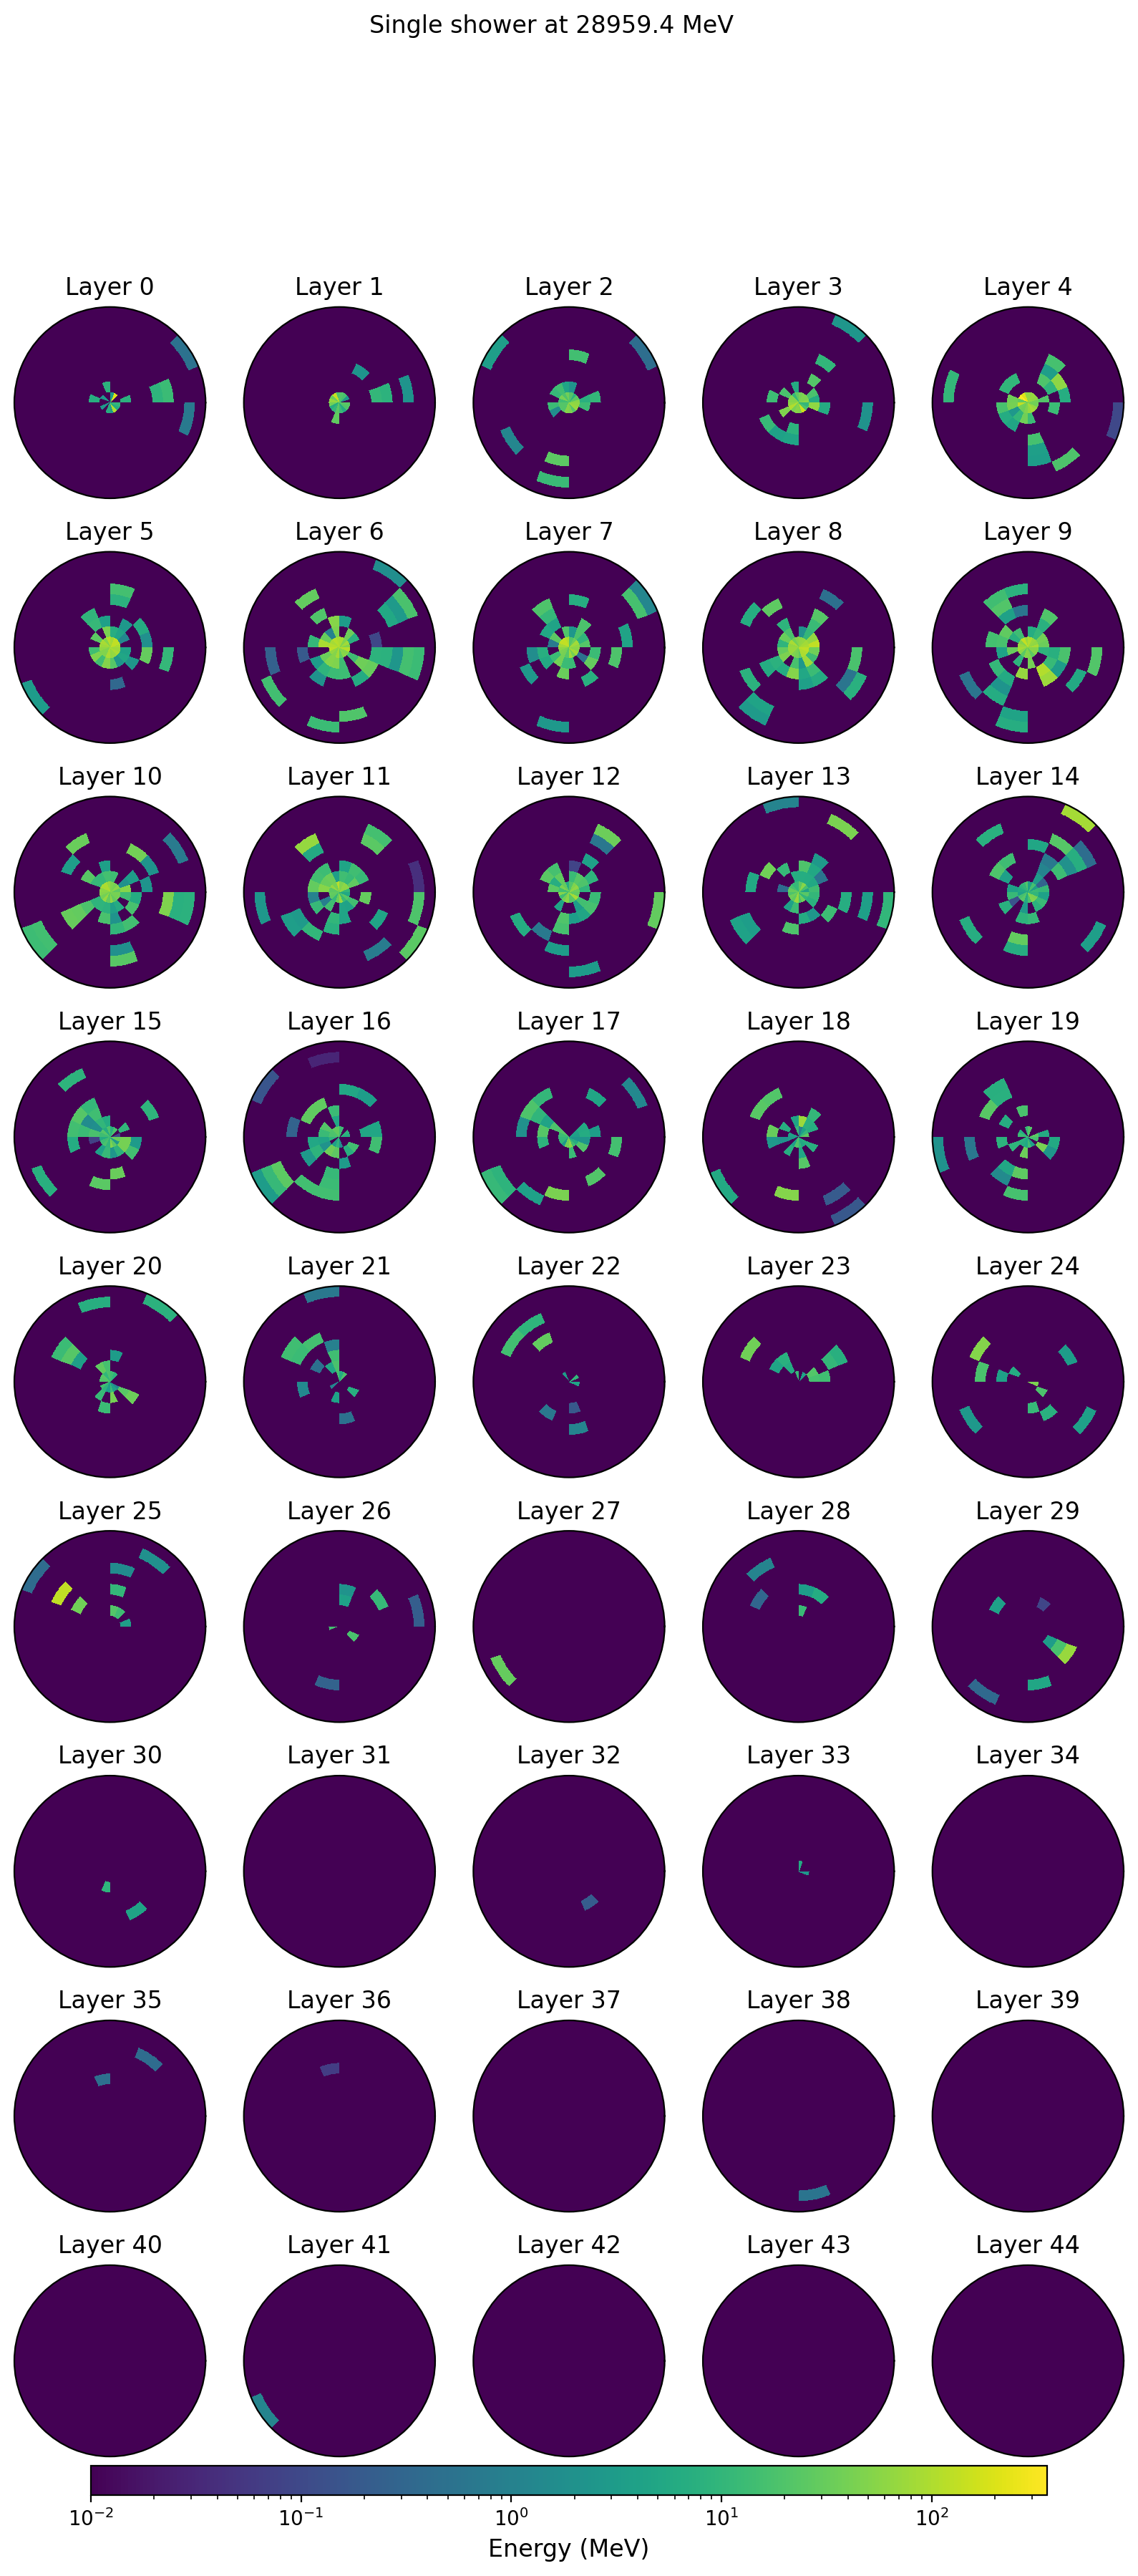

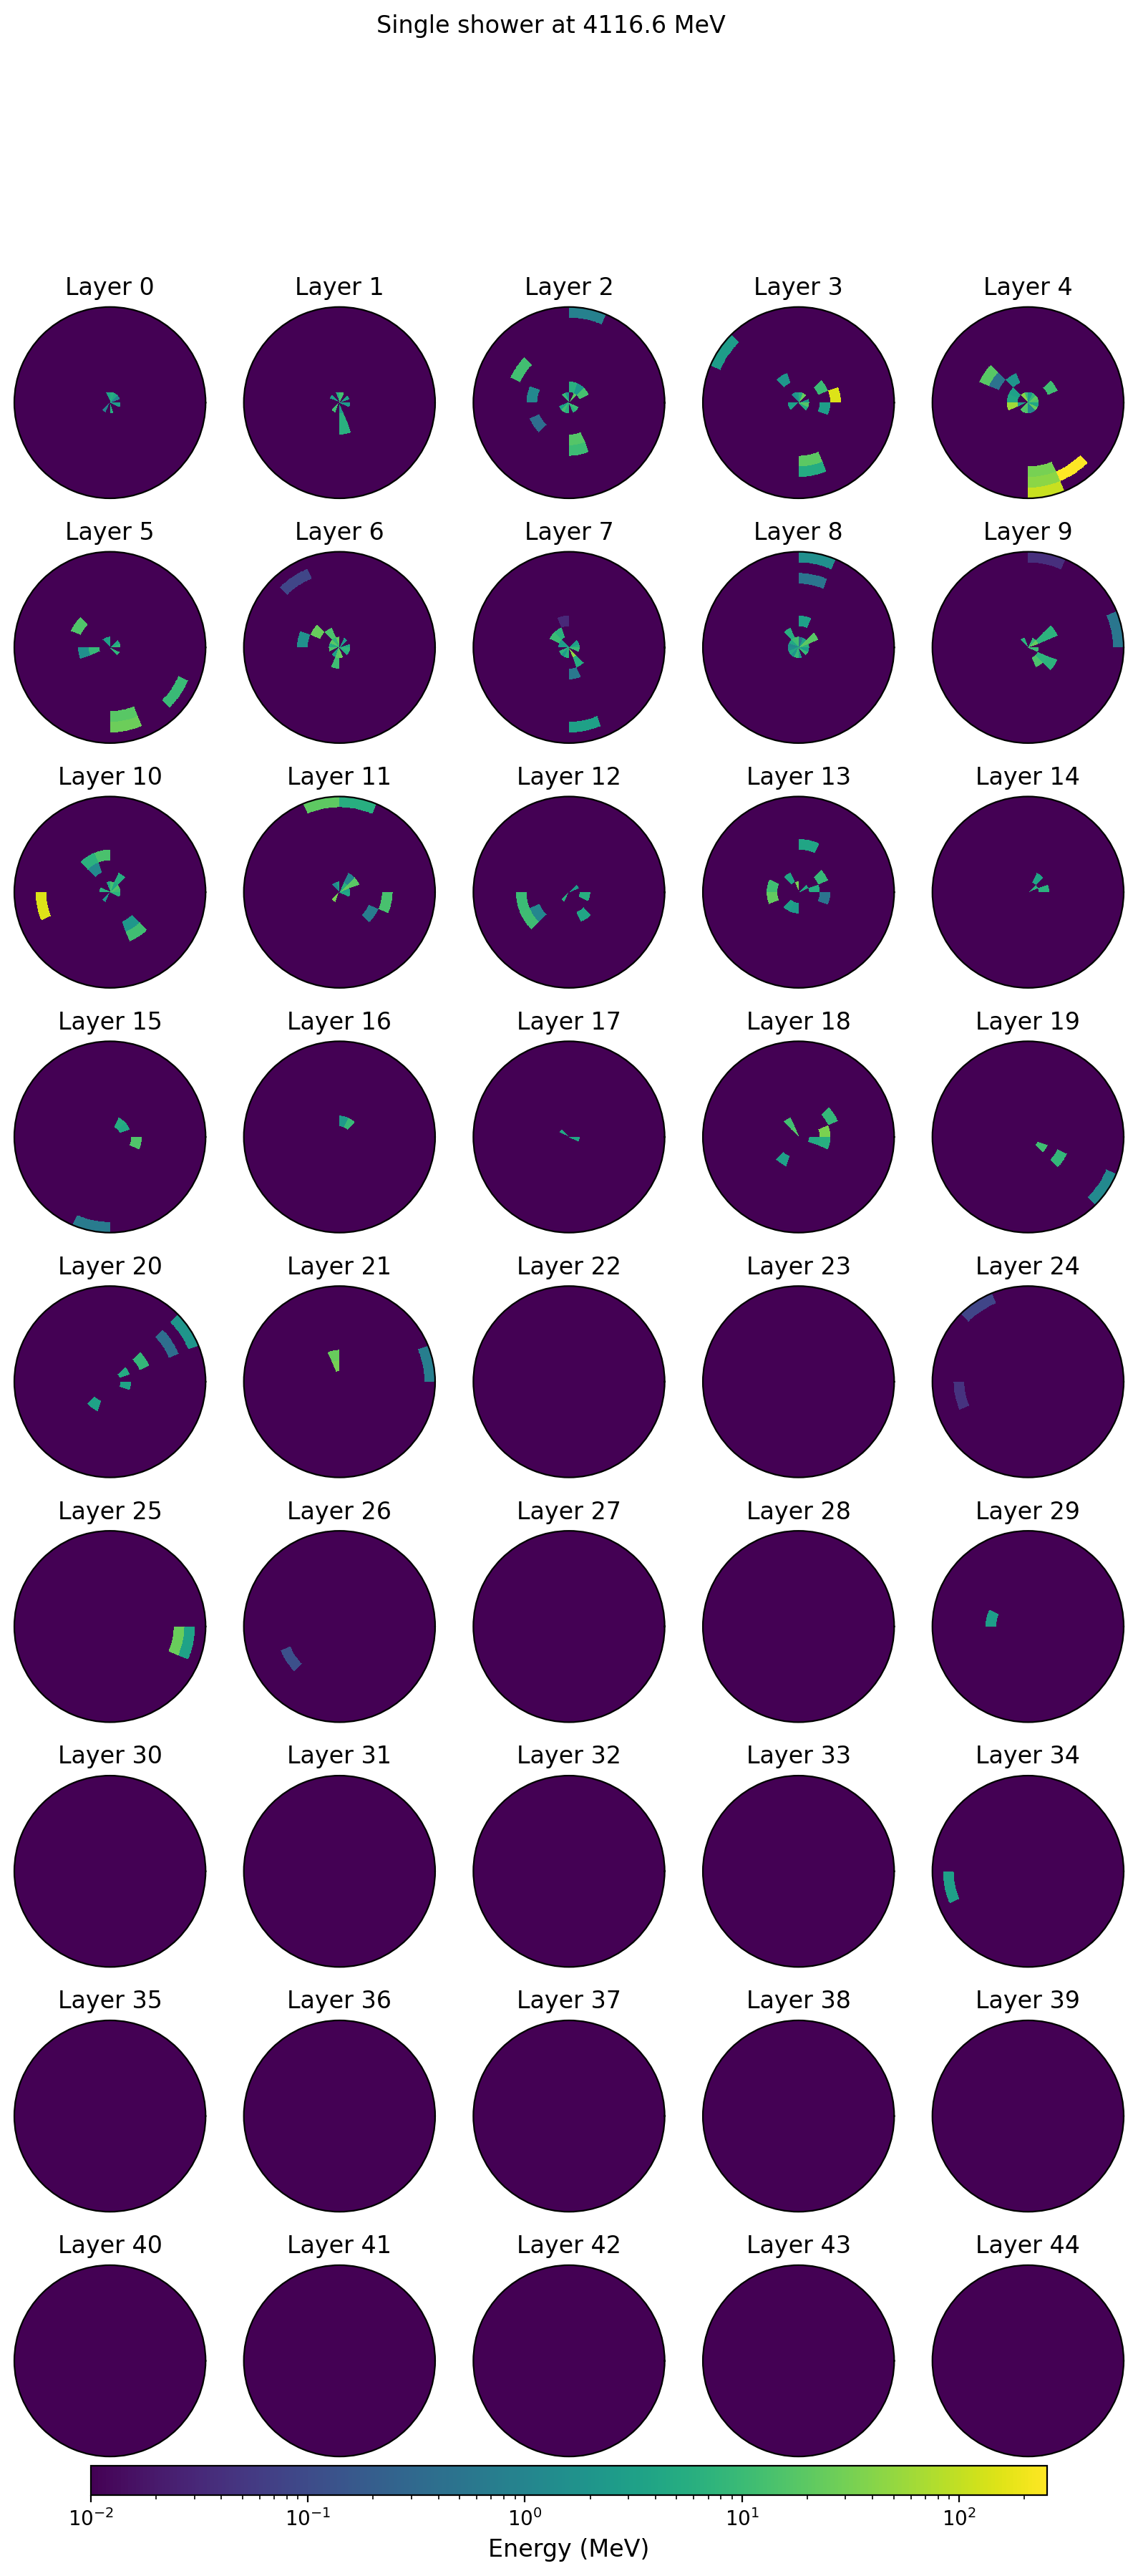

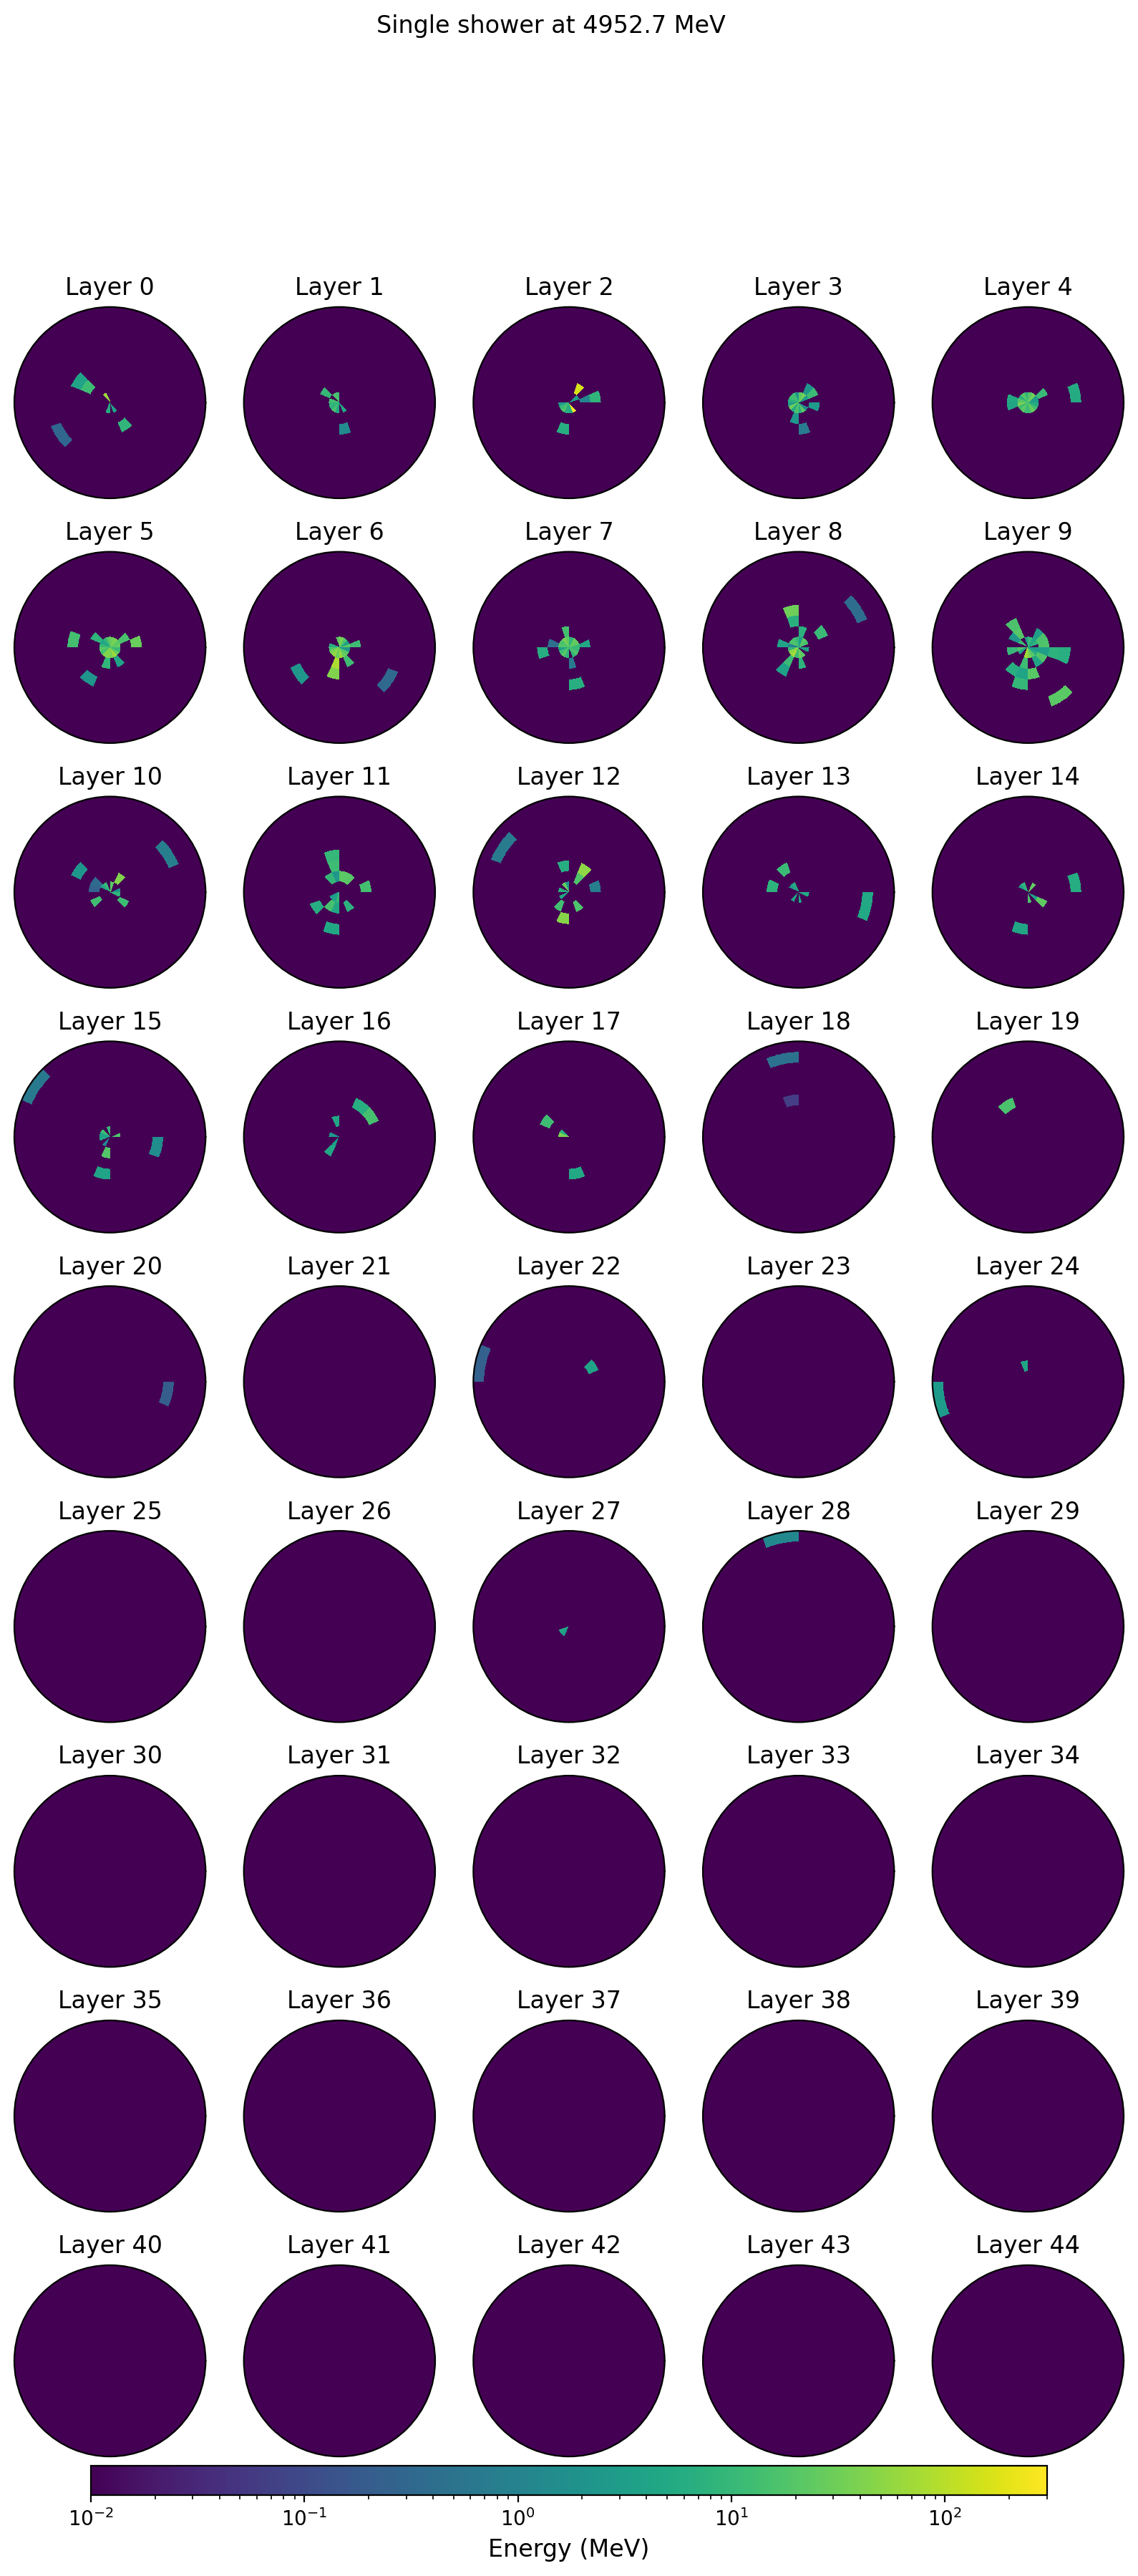

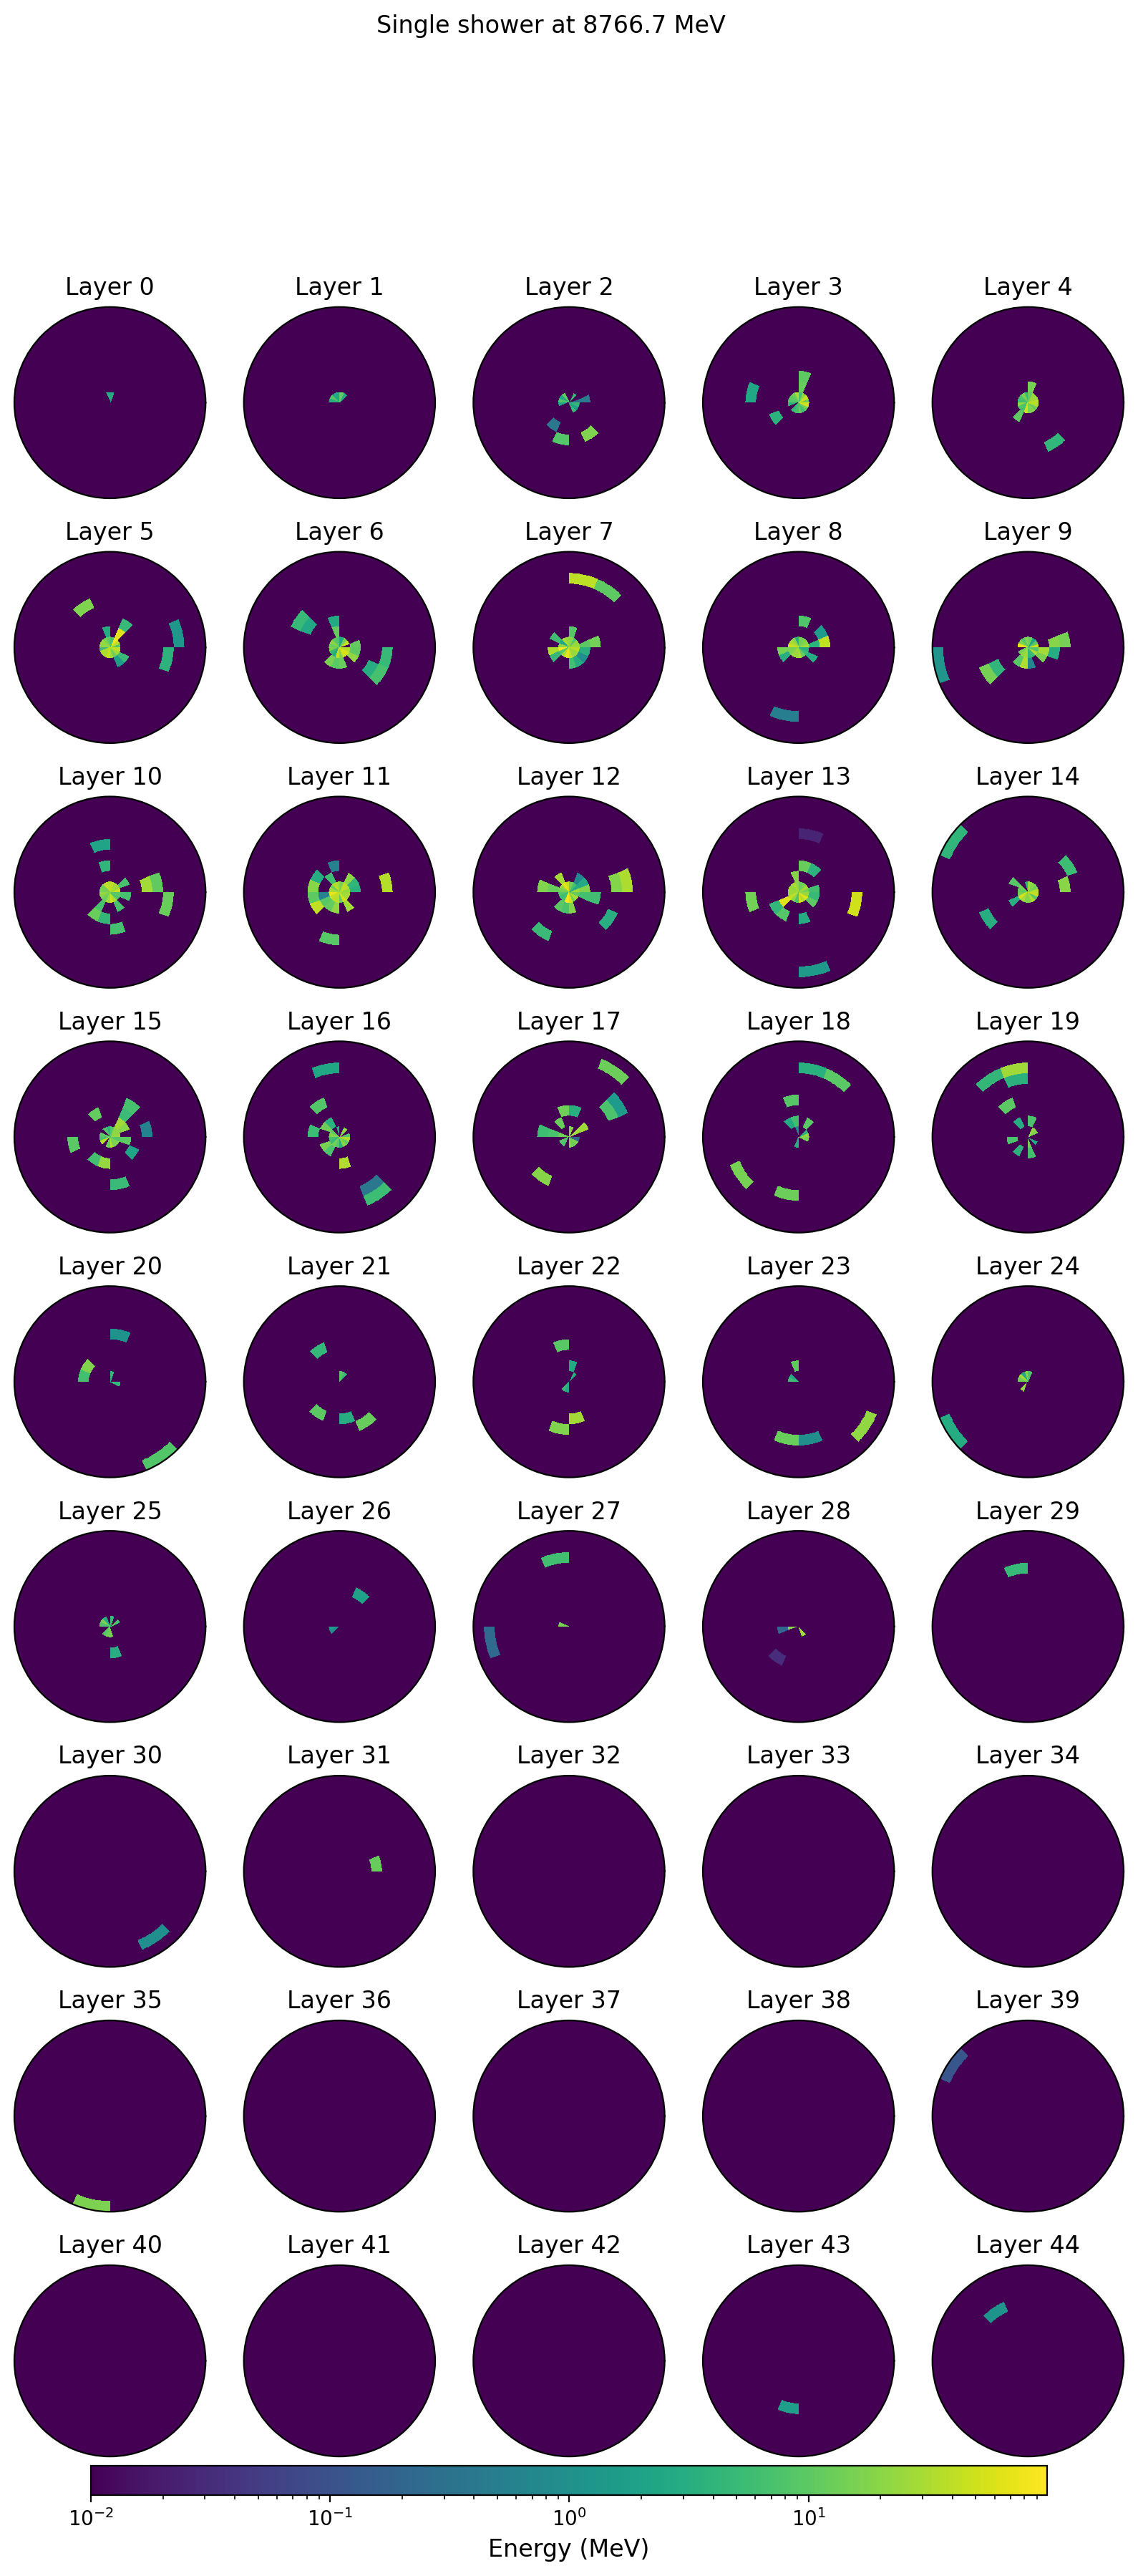

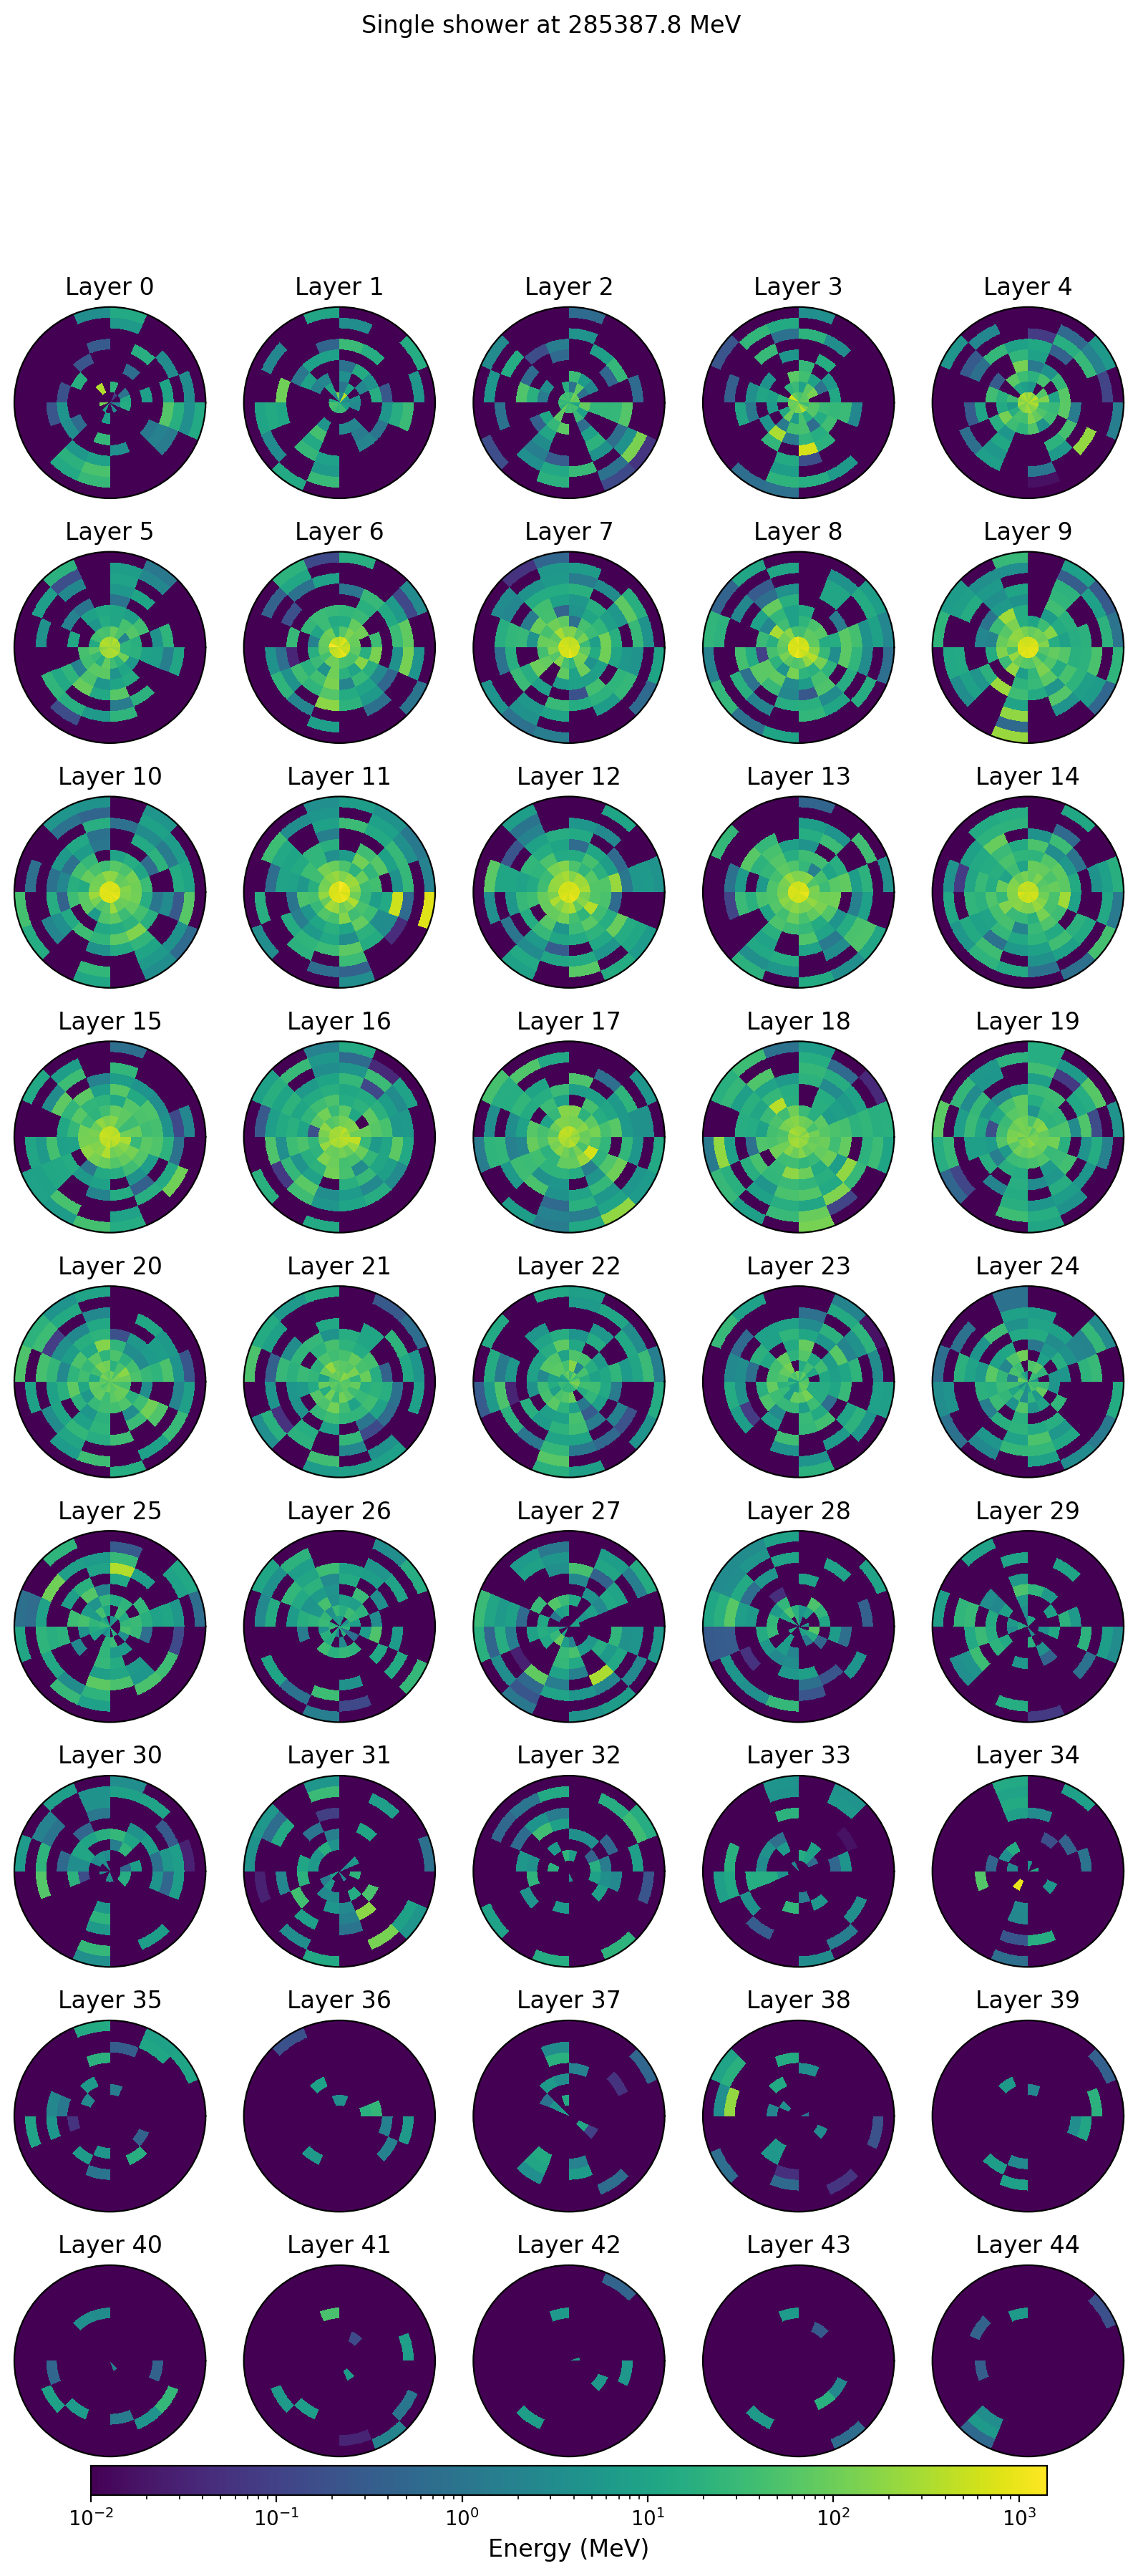

In [9]:
# looking at the first 5 showers:
# not providing a filename or passing 'None' does not save the plot
# functions return instance of matplotlib.pyplot.figure
# DrawSingleShower supports passing of multiple showers, but the will all get the same title
# passing a single shower allows individual titles
for i in range(5):
    _ = HLF_2.DrawSingleShower(showers[i], filename=None, 
                                title="Single shower at {:.1f} MeV".format(energies[i][0]))

In [34]:
#Util function to convert cynlindrial to cart


def polar_to_cart(polar_data,nr=9,nalpha=16,nx=12,ny=12):
    cart_img = np.zeros((nx,ny))
    ntotal = 0
    nfilled = 0

    if not hasattr(polar_to_cart, "x_interval"):
        polar_to_cart.x_interval = np.linspace(-1,1,nx)
        polar_to_cart.y_interval = np.linspace(-1,1,ny)
        polar_to_cart.alpha_pos = np.linspace(1e-5,1,nalpha)
        polar_to_cart.r_pos = np.linspace(1e-5,1,nr)

    for alpha in range(nalpha):
        for r in range(nr):
            if(polar_data[alpha,r] > 0):
                x = polar_to_cart.r_pos[r] * np.cos(polar_to_cart.alpha_pos[alpha]*np.pi*2)
                y = polar_to_cart.r_pos[r] * np.sin(polar_to_cart.alpha_pos[alpha]*np.pi*2)
                binx = np.argmax(polar_to_cart.x_interval>x)
                biny = np.argmax(polar_to_cart.y_interval>y)
                ntotal+=1
                if cart_img[binx,biny] >0:
                    nfilled+=1
                cart_img[binx,biny]+=polar_data[alpha,r]
    return cart_img